In [ ]:
from pathlib import Path

def find_repo_root(start=None) -> Path:
    p = Path(start or Path.cwd()).resolve()
    for q in (p, *p.parents):
        if (q / ".git").exists():
            return q
    raise RuntimeError("Could not find repo root (no .git found).")

ROOT = find_repo_root()
RUNS = ROOT / "runs"
RUNS.mkdir(exist_ok=True)

In [1]:
import sys
from pathlib import Path
# if notebook is in PMLS_project/notebooks, add PMLS_project
sys.path.insert(0, str(Path.cwd().parent))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import replace

In [4]:
from dreamingnetz._1d_ladder_helpers import SysConfig_1d, TrialConfig_1d , pool_orchestrator_stats_1d
from dreamingnetz._2d_ladder_helpers import               TrialConfig    , pool_orchestrator_stats
from dreamingnetz.init_and_checkpoints import SysConfig

from dreamingnetz.beta_ladder_search_1d import ladder_search_parallel
from dreamingnetz.beta_ladder_search import build_edge_list_two_sided_nearest_beta


In [5]:
import os, pickle, gzip

def save_results(path: str, results) -> None:
    os.makedirs(os.path.dirname(path) or ".", exist_ok=True)
    with gzip.open(path, "wb") as f:
        pickle.dump(results, f, protocol=pickle.HIGHEST_PROTOCOL)

def load_results(path: str):
    with gzip.open(path, "rb") as f:
        return pickle.load(f)

# example
#save_results("ladder/smoke_5dpt/results.pkl.gz", results)


In [6]:

results = load_results("ladder/smoke_5dpt/results.pkl.gz")

In [7]:
N = 500
α = 0.09

P = int(α*N)

In [8]:
t_grid = [0,0.05,0.10,0.20,0.50]

In [9]:
beta_by_t = results[0].beta_by_t

In [10]:
B = len(t_grid)

In [11]:
K = np.zeros(B)
for i in range (B):
    K[i]=beta_by_t[i].shape[0]
k_start = np.insert(np.cumsum(K),0,0)

In [12]:
edge_list = build_edge_list_two_sided_nearest_beta(beta_by_t,k_start)

In [13]:
results

[TrialResult(rid=0, beta_by_t=(array([0.3       , 0.53699158, 0.70331   , 0.79304651, 0.87017283,
        0.94399102, 1.0212555 , 1.11275108, 1.2120402 , 1.34285   ,
        1.45606201, 1.56596608, 1.6703801 , 1.77458036, 1.89186557,
        2.00915079, 2.27503133, 2.61732419, 2.95961705, 3.61657097,
        4.27352488, 9.        ]), array([0.3       , 0.52796313, 0.69577845, 0.80085867, 0.88486051,
        0.96361751, 1.04804577, 1.13879428, 1.23644411, 1.35178884,
        1.46761181, 1.56120582, 1.65483882, 1.75405742, 1.85327603,
        1.96296402, 2.07265201, 2.39451278, 2.78583856, 3.39357677,
        4.00131498, 9.        ]), array([0.3       , 0.54570413, 0.72185013, 0.84027401, 0.9312545 ,
        1.01160976, 1.09487563, 1.18497626, 1.28317394, 1.39523623,
        1.51198612, 1.61667606, 1.71807564, 1.81919011, 1.91738062,
        2.02176143, 2.13902267, 2.39155174, 2.72809572, 3.26071925,
        3.95004327, 9.        ]), array([0.3       , 0.52908383, 0.70277572, 0.81666432,

In [7]:
my_res = []
for t in t_grid:
    betas0 = np.geomspace(0.3, 9, 10)
    sys0  = SysConfig_1d(N=N, P=P, K=betas0.size, t=t,c=0, β=betas0,
                    mu_to_store=np.array([0]), #useless parameter
                    master_seed=12345, spin_init_mode="random")

    trial1 = TrialConfig_1d(equilibration_time=5000, sweeps_per_sample=20, n_samples=500)

    betas1, acc_stack1, I_ts_stack1 = ladder_search_parallel(
        sys_template=sys0, beta_init=betas0,
        trial=trial1, R_workers=14, R_total=28,

        A_low=0.18, A_high=0.45, A_star=0.36,
        q_lo=0.14,                 # fix 
        redistribute_every=2,      # number of inserts after which a reshape triggers in the next pass, this triggers very rarely
        low_max_for_reshape = 4,   # max number of lows to still trigger a reshape before the inserts can trigger
        n_hot = 0,                 # number of high T interfaces that ignore the high mask
        max_insert = 3,            # max number of inserts allowed between reshapes

        gamma_reshape=0.5,clip_reshape=(0.75, 1.35), # reshape strength and constraints on the stretching of Δβ_k

        K_max=45, max_passes=10, verbose=True, start_method = "spawn")
    my_res.append((betas1, acc_stack1, I_ts_stack1))


 
 
pass  1 | K=10 | 
 
acc_trig=[47 15  0  0  0  1  2  6 15]
 
acc_low= [46 14  0  0  0  0  2  5 13]
 
＋ insert after iface 1
＋ insert after iface 2
＋ insert after iface 3
 
 
pass  2 | K=13 | 
 
acc_trig=[47 51 42 12  6  2  8  0  1  2  6 15]
 
acc_low= [46 51 41  9  5  2  7  0  0  2  5 12]
 
↺ reshape (fixed K)
 
 
pass  3 | K=13 | 
 
acc_trig=[27 23 13  6 12  6 14  0  1  3  8 15]
 
acc_low= [26 22 10  6 11  6 13  0  1  3  7 12]
 
＋ insert after iface 2
＋ insert after iface 3
＋ insert after iface 4
 
 
pass  4 | K=16 | 
 
acc_trig=[27 23 48 41 35 37 41 45  6 14  0  1  3  8 15]
 
acc_low= [26 22 46 38 33 35 40 44  6 13  0  1  3  6 12]
 
↺ reshape (fixed K)
 
 
pass  5 | K=16 | 
 
acc_trig=[18 14 24 23 29 32 36 39 14 22  1  2  5 10 16]
 
acc_low= [18 13 20 22 27 32 35 38 14 21  1  2  4  8 13]
 
＋ insert after iface 1
＋ insert after iface 8
＋ insert after iface 10
 
 
pass  6 | K=19 | 
 
acc_trig=[18 51 42 24 24 28 32 36 39 44 49 22 17 27  3  5 10 16]
 
acc_low= [18 50 40 21 22 27 32 35

In [11]:
B = len(t_grid)

In [12]:
beta_by_t = []
for i in range (B):
    beta_by_t.append(my_res[i][0])

In [13]:
K = np.zeros(B)
for i in range (B):
    K[i]=beta_by_t[i].shape[0]
k_start = np.insert(np.cumsum(K),0,0)

In [13]:
sys2  = SysConfig(N=N, P=P,
                  t_grid=t_grid, K=K , beta_by_t=beta_by_t,
                  c=0,
                  mu_to_store=np.array([0]), #useless parameter
                  master_seed=12345, spin_init_mode="random")


In [15]:
edge_list = build_edge_list_two_sided_nearest_beta(beta_by_t,k_start)

In [16]:

trial2 = TrialConfig(equilibration_time=6000, sweeps_per_sample=50, n_samples=1000)


results = pool_orchestrator_stats(sys2, trial2, R_workers=14, R_total=28, start_method="spawn",edge_list=edge_list)

In [96]:
import matplotlib as mpl
def sharpen_mid(cmap, gamma=4, n=512, name=None):
    cmap = mpl.colormaps[cmap] if isinstance(cmap, str) else cmap
    x = np.linspace(0, 1, n)

    # symmetric power warp; gamma>1 => steeper transition near 0.5
    xw = np.where(
        x < 0.5,
        0.5 * (2*x)**gamma,
        1.0 - 0.5 * (2*(1-x))**gamma
    )

    cols = cmap(xw)
    return mpl.colors.LinearSegmentedColormap.from_list(
        name or f"{cmap.name}_sharpen{gamma:g}", cols, N=n
    )

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.colors import PowerNorm, BoundaryNorm, Normalize

def edge_meta(sys, edge_list: np.ndarray):
    edge_list = np.ascontiguousarray(edge_list, dtype=np.int64)
    r1 = edge_list[:, 0]
    r2 = edge_list[:, 1]
    b1 = sys.b_of_r[r1]
    b2 = sys.b_of_r[r2]
    t1 = sys.t_grid[b1].astype(np.float64, copy=False)
    t2 = sys.t_grid[b2].astype(np.float64, copy=False)
    beta1 = sys.beta[r1].astype(np.float64, copy=False)
    beta2 = sys.beta[r2].astype(np.float64, copy=False)
    return dict(r1=r1, r2=r2, b1=b1, b2=b2, t1=t1, t2=t2, beta1=beta1, beta2=beta2)


def _get_result_for_rid(results, rid: int):
    # results is a list[TrialResult], each has .rid
    for r in results:
        if int(r.rid) == int(rid):
            return r
    raise KeyError(f"rid={rid} not found in results (have {[int(r.rid) for r in results[:10]]} ...)")


def _attempt_weighted_replica_avg(prob_2E: np.ndarray, att_2E: np.ndarray) -> np.ndarray:
    """
    prob_2E: (2,E) probabilities in [0,1]
    att_2E : (2,E) attempt counts
    returns: (E,) attempt-weighted avg prob
    """
    att = att_2E.astype(np.float64, copy=False)
    p   = prob_2E.astype(np.float64, copy=False)
    den = att.sum(axis=0)
    num = (p * att).sum(axis=0)
    out = np.full(den.shape[0], np.nan, dtype=np.float64)
    m = den > 0
    out[m] = num[m] / den[m]
    return out


def plot_pt_graph_tbeta(cmap,
    sys,
    results,
    edge_list,
    *,
    rid=0,
    min_attempts=1,
    add_horizontal=True,
    add_nodes=True,
    y_axis="beta",          # <-- NEW: "beta" or "T"
    log_y=True,             # <-- was log_beta
    invert_y_for_T=False,    # <-- optional: keep "cold up" when plotting T
    title=None,
):
    res = _get_result_for_rid(results, rid)

    def _y_from_beta(beta: np.ndarray) -> np.ndarray:
        beta = np.asarray(beta, dtype=np.float64)
        if y_axis == "beta":
            return beta
        elif y_axis == "T":
            if np.any(beta <= 0):
                raise ValueError("Cannot plot T=1/beta with beta<=0 present.")
            return 1.0 / beta
        else:
            raise ValueError("y_axis must be 'beta' or 'T'")

    # --- vertical edges acceptance (attempt-weighted over replicas)
    att_v = np.asarray(res.attempted_v, dtype=np.float64)  # (2,E)
    acc_v = np.asarray(res.acc_v,       dtype=np.float64)  # (2,E)
    E = int(edge_list.shape[0])

    if E == 0:
        a_v = np.empty((0,), dtype=np.float64)
        att_sum = np.empty((0,), dtype=np.float64)
    else:
        att_sum = att_v.sum(axis=0)
        a_v = _attempt_weighted_replica_avg(acc_v, att_v)
        a_v = np.where(att_sum >= float(min_attempts), a_v, np.nan)

    meta = edge_meta(sys, edge_list)

    # segments for vertical edges (t, y)
    y1 = _y_from_beta(meta["beta1"])
    y2 = _y_from_beta(meta["beta2"])
    segs_v = np.stack(
        [np.stack([meta["t1"], y1], axis=1),
         np.stack([meta["t2"], y2], axis=1)],
        axis=1
    ) if E > 0 else np.empty((0,2,2), dtype=np.float64)

    # --- horizontal edges (adjacent r inside each ladder b)
    segs_h = []
    a_h = []
    if add_horizontal:
        for b in range(sys.B):
            r0, r1 = int(sys.k_start[b]), int(sys.k_start[b+1])
            bet = sys.beta[r0:r1].astype(np.float64, copy=False)
            yb  = _y_from_beta(bet)   # <-- HERE
            t = float(sys.t_grid[b])

            if (r1 - r0) >= 2:
                acc_iface = np.asarray(res.acc_h_by_t[b], dtype=np.float64)  # (2,Kb-1)
                acc_iface = np.nanmean(acc_iface, axis=0)                    # (Kb-1,)

                for k in range((r1 - r0) - 1):
                    segs_h.append([[t, yb[k]], [t, yb[k+1]]])
                    a_h.append(acc_iface[k])

        segs_h = np.asarray(segs_h, dtype=np.float64) if segs_h else np.empty((0,2,2), dtype=np.float64)
        a_h    = np.asarray(a_h,    dtype=np.float64) if a_h    else np.empty((0,),    dtype=np.float64)

    # --- shared color normalization
    vals = []
    if E > 0 and np.any(np.isfinite(a_v)): vals.append(a_v[np.isfinite(a_v)])
    if add_horizontal and a_h.size and np.any(np.isfinite(a_h)): vals.append(a_h[np.isfinite(a_h)])
    if vals:
        vv = np.concatenate(vals)
        vmin, vmax = float(np.nanmin(vv)), float(np.nanmax(vv))
    else:
        vmin, vmax = 0.0, 1.0
    norm = Normalize(vmin=vmin, vmax=vmax)
    norm = PowerNorm(gamma=0.5, vmin=0.0, vmax=1.0, clip=True)
    fig, ax = plt.subplots(figsize=(8.0, 12.4))

    if add_horizontal and segs_h.shape[0] > 0:
        lc_h = LineCollection(segs_h, array=a_h, norm=norm,cmap = cmap)
        lc_h.set_linewidth(3.0)
        ax.add_collection(lc_h)

    if E > 0:
        lc_v = LineCollection(segs_v, array=a_v, norm=norm,cmap = cmap)
        lc_v.set_linewidth(3.0)
        ax.add_collection(lc_v)

    # nodes
    if add_nodes:
        t_of_r = sys.t_grid[sys.b_of_r].astype(np.float64, copy=False)
        y_of_r = _y_from_beta(sys.beta.astype(np.float64, copy=False))  # <-- HERE
        ax.scatter(t_of_r, y_of_r, s=30,zorder=10,color='black')

    ax.autoscale()
    ax.set_xlabel("t")
    ax.set_ylabel("beta" if y_axis == "beta" else "T = 1/beta")

    if log_y:
        ax.set_yscale("log")

    # optional: keep same “cold up” visual convention as beta plots
    if y_axis == "T" and invert_y_for_T:
        ax.invert_yaxis()

    ax.set_title(title or f"2D PT graph in (t,{ax.get_ylabel()}) for rid={rid}  |  colors=acceptance")
    sm = ScalarMappable(norm=norm,cmap = cmap)
    cb = fig.colorbar(sm, ax=ax)
    cb.set_label("acceptance (vertical: attempt-weighted avg; horizontal: avg replicas)")

    plt.tight_layout()
    plt.show()



In [93]:
plt.rcParams["figure.facecolor"] = "#ffffffff"  # light grey
plt.rcParams["axes.facecolor"]   = "#ffffff6c"

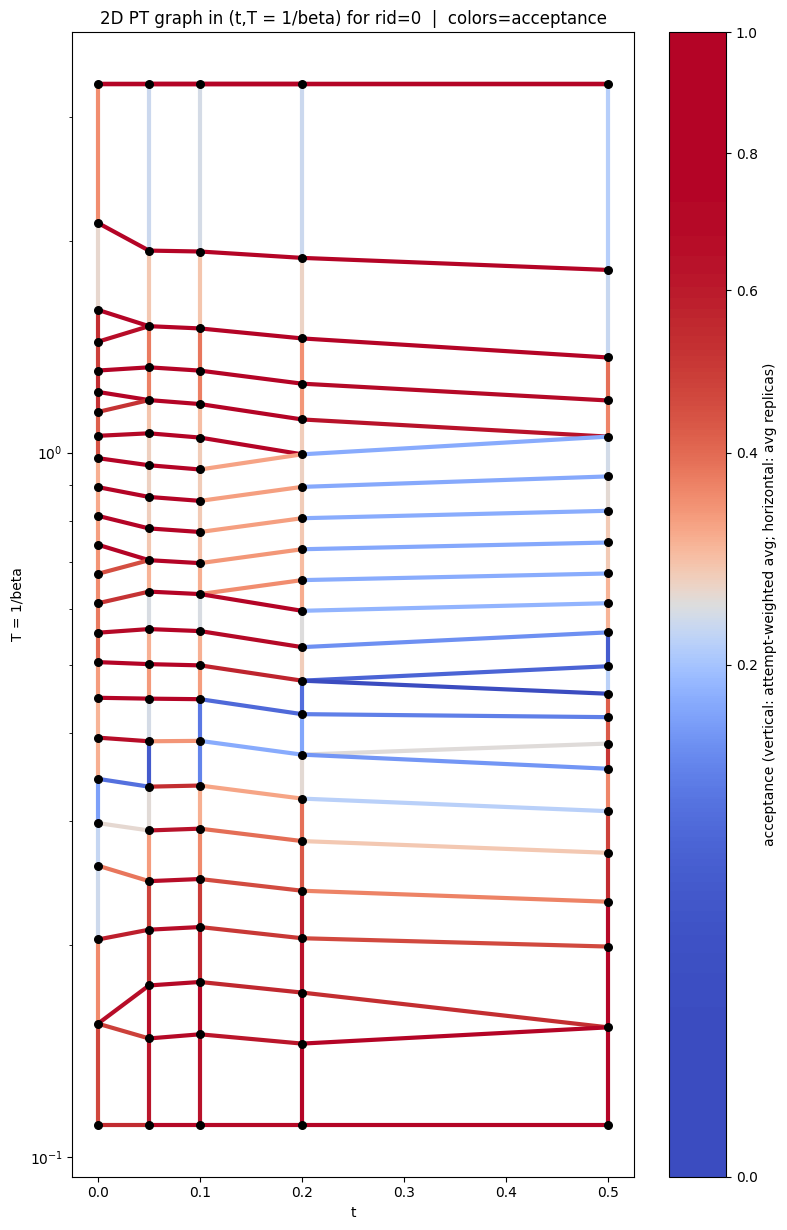

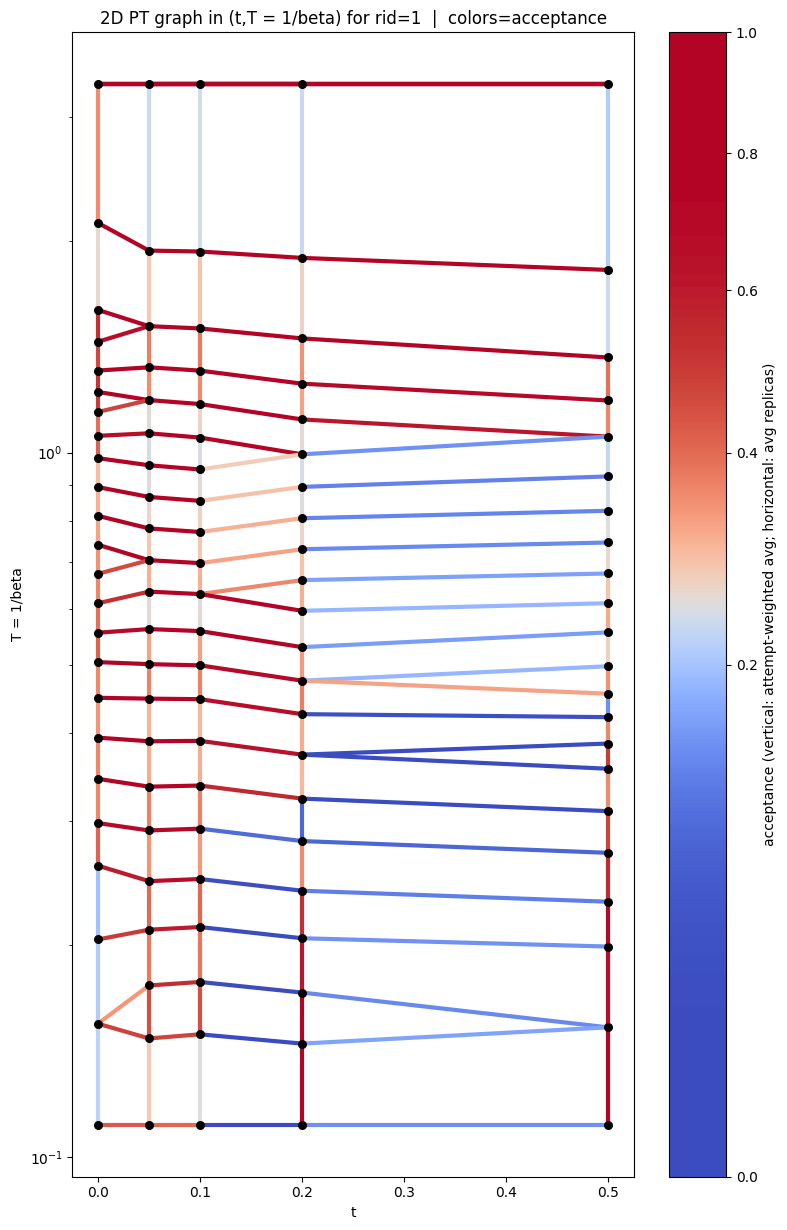

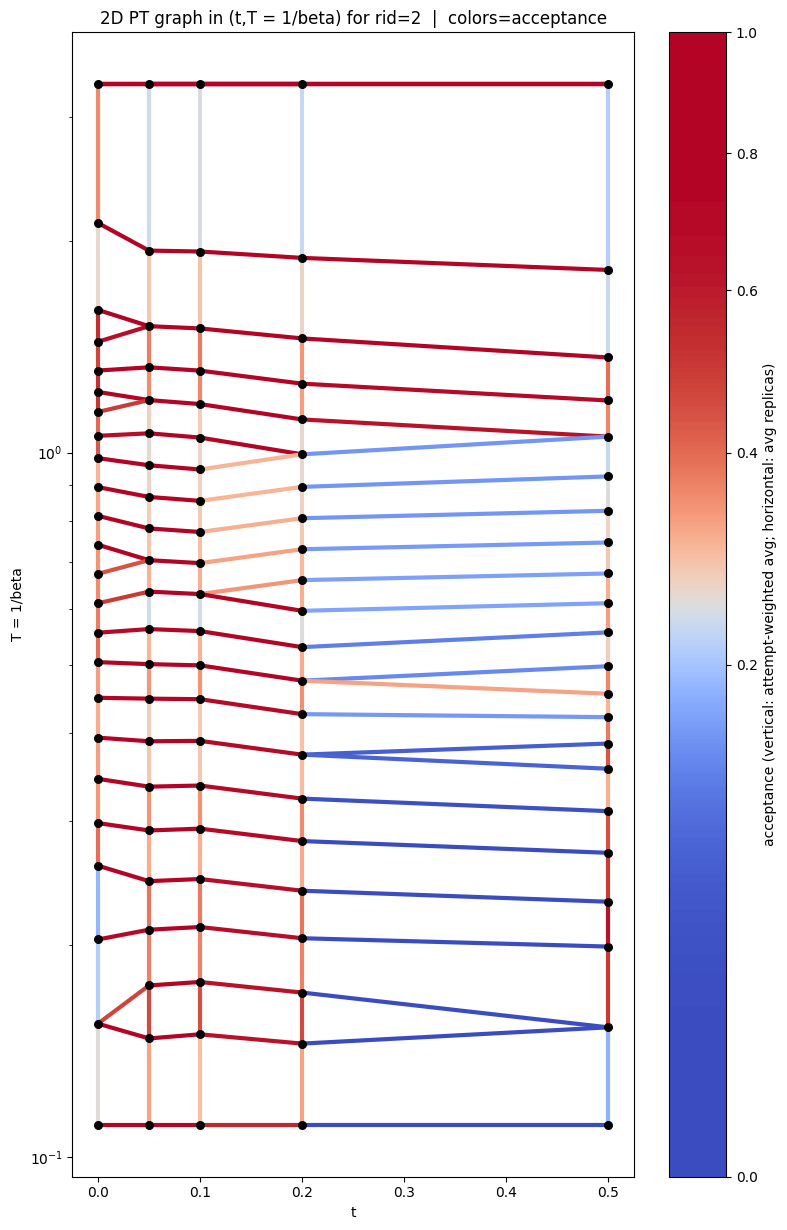

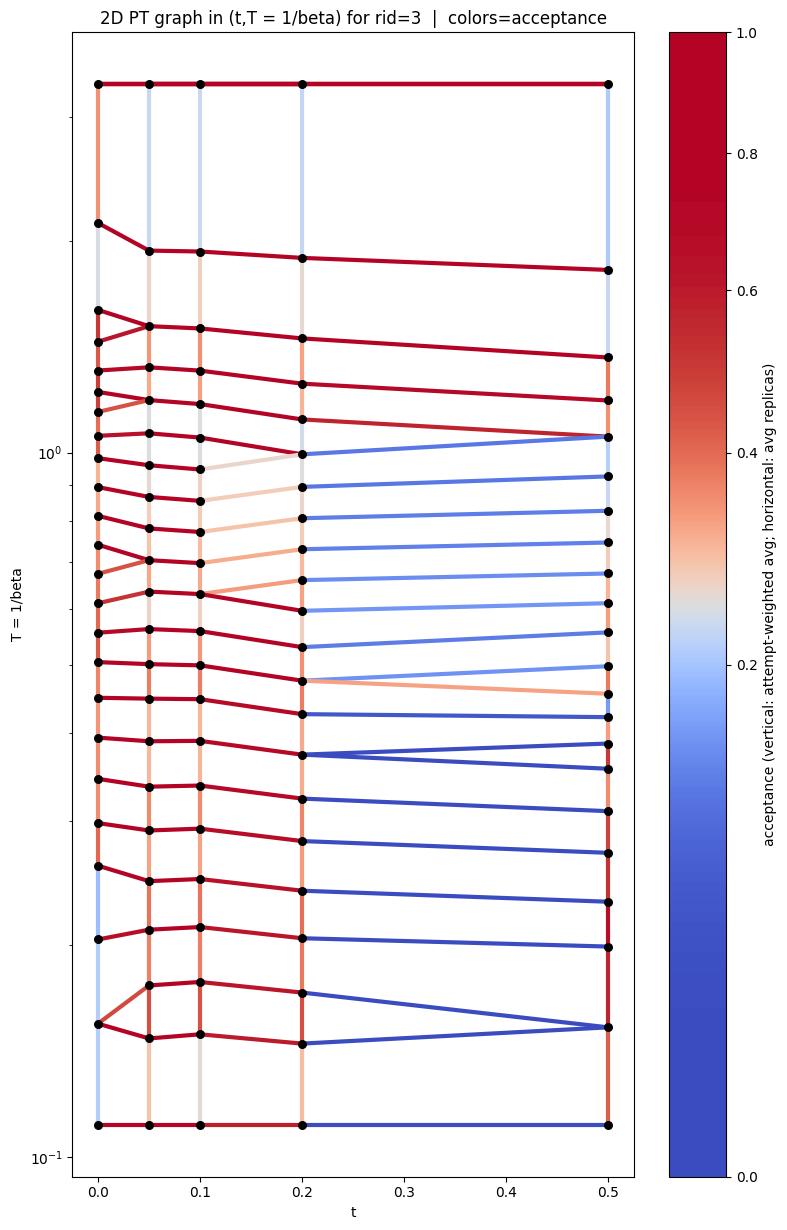

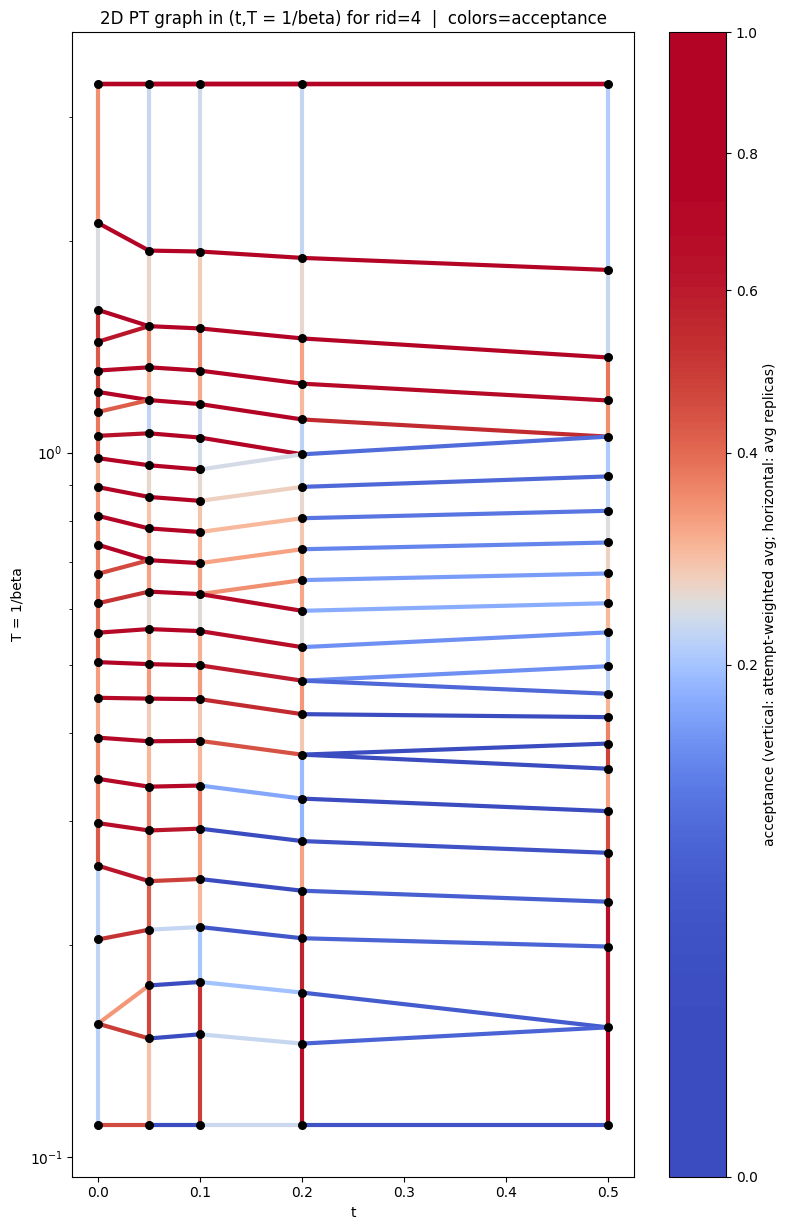

In [113]:
for r in range(5):
    plot_pt_graph_tbeta(sharpen_mid("coolwarm"),sys2, results, edge_list, rid=r, y_axis="T", log_y=True)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize, LogNorm
from matplotlib.cm import ScalarMappable

# ============================================================
# 0) Prepare metadata once
# ============================================================

@dataclass(frozen=True)
class PT2DMeta:
    # geometry
    R: int
    B: int
    beta: np.ndarray      # (R,)
    b_of_r: np.ndarray    # (R,)
    t_grid: np.ndarray    # (B,)
    t_of_r: np.ndarray    # (R,)
    k_start: np.ndarray   # (B+1,)

    # vertical edges
    edge_list: np.ndarray   # (E,2) int64
    E: int
    v_key_to_e: dict        # maps (min(u,v),max(u,v)) -> e

    # horizontal interfaces (adjacent within each row)
    H: int
    h_edge_of_r: np.ndarray  # (R-1,) int64 ; -1 at row boundaries; else interface id 0..H-1
    h_u: np.ndarray          # (H,) left endpoint u
    h_v: np.ndarray          # (H,) right endpoint v


def pt2d_prepare(sys, edge_list: np.ndarray) -> PT2DMeta:
    beta   = np.asarray(sys.beta, dtype=np.float64)
    b_of_r = np.asarray(sys.b_of_r, dtype=np.int64)
    t_grid = np.asarray(sys.t_grid, dtype=np.float64)
    k_start = np.asarray(sys.k_start, dtype=np.int64)
    R = int(beta.shape[0])
    B = int(k_start.shape[0] - 1)

    t_of_r = t_grid[b_of_r]

    # vertical edges
    edge_list = np.ascontiguousarray(edge_list, dtype=np.int64)
    E = int(edge_list.shape[0])
    v_key_to_e = {}
    for e in range(E):
        u, v = int(edge_list[e, 0]), int(edge_list[e, 1])
        if u > v: u, v = v, u
        v_key_to_e[(u, v)] = e

    # horizontal interfaces: build a flat list for all within-row adjacencies
    h_edge_of_r = np.full(R - 1, -1, dtype=np.int64)
    h_u = []
    h_v = []
    hid = 0
    for b in range(B):
        r0, r1 = int(k_start[b]), int(k_start[b + 1])
        for u in range(r0, r1 - 1):
            v = u + 1
            h_edge_of_r[u] = hid
            h_u.append(u); h_v.append(v)
            hid += 1
    H = hid

    return PT2DMeta(
        R=R, B=B, beta=beta, b_of_r=b_of_r, t_grid=t_grid, t_of_r=t_of_r, k_start=k_start,
        edge_list=edge_list, E=E, v_key_to_e=v_key_to_e,
        H=H, h_edge_of_r=h_edge_of_r, h_u=np.asarray(h_u, dtype=np.int64), h_v=np.asarray(h_v, dtype=np.int64)
    )


# ============================================================
# 1) Define hot/cold sets (boxes)
# ============================================================

def pt2d_end_sets(meta: PT2DMeta, *,
                  hot_k=0, hot_all_rows=True,
                  cold_b=0, cold_top=1):
    """
    Hot set:
      - by default, the k=0 node in every row (all t)
    Cold set:
      - by default, the top 'cold_top' nodes (largest beta) in row cold_b (e.g. t=0 row)

    Returns (hot_idx, cold_idx) as arrays of box indices r.
    """
    hot_idx = []
    rows = range(meta.B) if hot_all_rows else [cold_b]
    for b in rows:
        r0, r1 = int(meta.k_start[b]), int(meta.k_start[b+1])
        Kb = r1 - r0
        k = hot_k if hot_k >= 0 else (Kb + hot_k)
        if not (0 <= k < Kb):
            raise ValueError(f"hot_k out of range for row b={b}")
        hot_idx.append(r0 + k)

    r0, r1 = int(meta.k_start[cold_b]), int(meta.k_start[cold_b+1])
    Kb = r1 - r0
    cold_top = int(max(1, cold_top))
    ks = np.arange(max(0, Kb - cold_top), Kb, dtype=np.int64)
    cold_idx = r0 + ks

    return np.asarray(hot_idx, dtype=np.int64), np.asarray(cold_idx, dtype=np.int64)


# ============================================================
# 2) Passage metrics and detour (per chain + pooled)
# ============================================================

def _as_I2(I_ts):
    I = np.asarray(I_ts)
    if I.ndim != 3 or I.shape[0] != 2:
        raise ValueError("Expected I_ts shape (2, T, R).")
    return I.astype(np.int64, copy=False)

def _burn_idx(T, burn_in):
    if isinstance(burn_in, float):
        if not (0 <= burn_in < 1):
            raise ValueError("burn_in float must be in [0,1).")
        t0 = int(np.floor(burn_in * T))
    else:
        t0 = int(burn_in)
    return max(0, min(t0, T-1))

def pt2d_passage_metrics_2chains(I_ts_2TR, meta: PT2DMeta,
                                hot_idx, cold_idx, *,
                                burn_in=0.1,
                                record_tmax=True):
    """
    Computes:
      tau_hc, tau_ch, rt (hot->cold->hot), and detour tmax_hc
    Time unit is "saved snapshots" (i.e. swap-pass ticks). If you want macro-steps, divide by 3.

    Returns:
      dict with per_chain (2 dicts) + pooled + summary
    """
    I2 = _as_I2(I_ts_2TR)  # (2,T,R)
    C, T, R = I2.shape
    t0 = _burn_idx(T, burn_in)

    hot_idx = np.asarray(hot_idx, dtype=np.int64)
    cold_idx = np.asarray(cold_idx, dtype=np.int64)

    t_of_r = meta.t_of_r
    pos = np.empty(R, dtype=np.int64)  # reused

    def run_one(I):
        last_end = np.zeros(R, dtype=np.int8)      # +1 hot, -1 cold, 0 none
        last_t   = np.full(R, -1, dtype=np.int64)

        hot_start = np.full(R, -1, dtype=np.int64)
        seen_cold = np.zeros(R, dtype=bool)

        active = np.zeros(R, dtype=bool)
        tmax   = np.full(R, -np.inf, dtype=np.float64)

        tau_hc, tau_ch, rt, tmax_hc = [], [], [], []

        for tt in range(t0, T):
            It = I[tt]

            if record_tmax:
                pos[It] = np.arange(R, dtype=np.int64)   # label -> box
                t_cur = t_of_r[pos]                      # label -> t
                a = np.flatnonzero(active)
                if a.size:
                    tmax[a] = np.maximum(tmax[a], t_cur[a])

            wH = It[hot_idx]
            wC = It[cold_idx]

            # cold hits
            for w in np.ravel(wC):
                w = int(w)
                if last_end[w] == +1 and last_t[w] != -1:
                    tau_hc.append(tt - last_t[w])

                if hot_start[w] != -1:
                    seen_cold[w] = True
                    if record_tmax and active[w]:
                        tmax_hc.append(float(tmax[w]))
                        active[w] = False
                        tmax[w] = -np.inf

                last_end[w] = -1
                last_t[w] = tt

            # hot hits
            for w in np.ravel(wH):
                w = int(w)
                if last_end[w] == -1 and last_t[w] != -1:
                    tau_ch.append(tt - last_t[w])

                if hot_start[w] != -1 and seen_cold[w]:
                    rt.append(tt - hot_start[w])

                hot_start[w] = tt
                seen_cold[w] = False

                if record_tmax:
                    active[w] = True
                    tmax[w] = t_cur[w]

                last_end[w] = +1
                last_t[w] = tt

        return dict(
            tau_hc=np.asarray(tau_hc, dtype=np.int64),
            tau_ch=np.asarray(tau_ch, dtype=np.int64),
            rt=np.asarray(rt, dtype=np.int64),
            tmax_hc=np.asarray(tmax_hc, dtype=np.float64)
        )

    per = [run_one(I2[0]), run_one(I2[1])]

    def cat(key, dtype):
        arrs = [p[key] for p in per if p[key].size]
        return np.concatenate(arrs, axis=0).astype(dtype, copy=False) if arrs else np.empty((0,), dtype=dtype)

    pooled = dict(
        tau_hc=cat("tau_hc", np.int64),
        tau_ch=cat("tau_ch", np.int64),
        rt=cat("rt", np.int64),
        tmax_hc=cat("tmax_hc", np.float64),
    )

    def med(x): return float(np.median(x)) if x.size else np.nan

    summary = dict(
        rt_cnt=[int(per[c]["rt"].size) for c in (0, 1)],
        rt_med=[med(per[c]["rt"]) for c in (0, 1)],
        rt_med_pooled=med(pooled["rt"]),
        tau_hc_med_pooled=med(pooled["tau_hc"]),
        tau_ch_med_pooled=med(pooled["tau_ch"]),
        tmax_med_pooled=med(pooled["tmax_hc"]),
        # convert to macro-step units if you want:
        rt_med_pooled_macro=med(pooled["rt"]) / 3.0 if pooled["rt"].size else np.nan,
    )

    return dict(per_chain=per, pooled=pooled, summary=summary)


# ============================================================
# 3) Flow field f(r) averaged over 2 chains (denom-weighted)
# ============================================================

def pt2d_flow_field_2chains(I_ts_2TR, meta: PT2DMeta,
                           hot_idx, cold_idx, *,
                           burn_in=0.1):
    """
    f[r] = P(last end visited was hot | currently at node r), estimated by last-end labeling.
    Returns: f_avg (R,), den_sum (R,)
    """
    I2 = _as_I2(I_ts_2TR)
    C, T, R = I2.shape
    t0 = _burn_idx(T, burn_in)

    hot_idx = np.asarray(hot_idx, dtype=np.int64)
    cold_idx = np.asarray(cold_idx, dtype=np.int64)

    def run_one(I):
        label_state = np.zeros(R, dtype=np.int8)  # per label: +1 hot, -1 cold, 0 unknown
        num = np.zeros(R, dtype=np.float64)
        den = np.zeros(R, dtype=np.float64)

        for tt in range(t0, T):
            It = I[tt]
            label_state[It[hot_idx]]  = +1
            label_state[It[cold_idx]] = -1
            st = label_state[It]  # state at node r
            known = (st != 0)
            den[known] += 1.0
            num[known] += (st[known] == +1)

        return num, den

    num0, den0 = run_one(I2[0])
    num1, den1 = run_one(I2[1])

    num = num0 + num1
    den = den0 + den1
    f = np.full(R, np.nan, dtype=np.float64)
    m = den > 0
    f[m] = num[m] / den[m]
    return f, den


# ============================================================
# 4) Edge traversal counts from consecutive I snapshots
#    (requires thin=1 implicitly; use full stored series)
# ============================================================

def _swap_pairs_from_two_perms(p, q):
    """
    Vectorized swap reconstruction assuming p->q is a disjoint set of transpositions.
    Returns arrays (u,v) with u<v.
    """
    diff = np.flatnonzero(p != q)
    if diff.size == 0:
        return np.empty((0,), dtype=np.int64), np.empty((0,), dtype=np.int64)

    # Build inverse mapping for labels appearing in q at the changed positions.
    # inv[label] = index in diff where that label sits in q.
    qD = q[diff]
    inv = np.empty(p.shape[0], dtype=np.int64)
    inv.fill(-1)
    inv[qD] = np.arange(diff.size, dtype=np.int64)

    # partner of u is where p[u] ended up in q
    pu = p[diff]
    partner_idx = inv[pu]
    v = diff[partner_idx]

    u = diff
    u2 = np.minimum(u, v)
    v2 = np.maximum(u, v)

    # keep each swap once: u < v and take only those where u is the min endpoint
    keep = (u2 == u) & (u != v)
    u2 = u2[keep]
    v2 = v2[keep]

    # unique (should already be unique, but be safe)
    if u2.size:
        key = u2.astype(np.int64) * p.shape[0] + v2
        order = np.argsort(key)
        key = key[order]; u2 = u2[order]; v2 = v2[order]
        uniq = np.concatenate([[True], key[1:] != key[:-1]])
        u2 = u2[uniq]; v2 = v2[uniq]

    return u2.astype(np.int64), v2.astype(np.int64)


def pt2d_edge_traversal_counts_2chains(I_ts_2TR, meta: PT2DMeta, *, burn_in=0.1):
    """
    Returns:
      counts_v (E,)    : accepted vertical swaps per edge (pooled over 2 chains)
      counts_h (H,)    : accepted horizontal swaps per interface (pooled over 2 chains)
      totals_by_pass   : dict with totals for {odd, vertical, even} passes
    """
    I2 = _as_I2(I_ts_2TR)
    C, T, R = I2.shape
    t0 = _burn_idx(T, burn_in)

    counts_v = np.zeros(meta.E, dtype=np.int64)
    counts_h = np.zeros(meta.H, dtype=np.int64)

    totals = {"odd": 0, "vertical": 0, "even": 0}

    # diff between idx and idx+1 corresponds to:
    # idx%3==0 : after even -> after odd  => "odd"
    # idx%3==1 : after odd  -> after vert => "vertical"
    # idx%3==2 : after vert -> next even  => "even"
    def pass_type(idx):
        m = idx % 3
        return "odd" if m == 0 else ("vertical" if m == 1 else "even")

    for c in (0, 1):
        I = I2[c]
        for idx in range(t0, T - 1):
            p = I[idx]
            q = I[idx + 1]
            u, v = _swap_pairs_from_two_perms(p, q)
            if u.size == 0:
                continue

            ptype = pass_type(idx)
            totals[ptype] += int(u.size)

            if ptype == "vertical":
                # must be in edge_list
                for uu, vv in zip(u, v):
                    e = meta.v_key_to_e.get((int(uu), int(vv)), None)
                    if e is not None:
                        counts_v[e] += 1
            else:
                # horizontal swaps should be adjacent; map via left endpoint
                left = np.minimum(u, v)
                for uu in left:
                    hid = meta.h_edge_of_r[int(uu)]
                    if hid >= 0:
                        counts_h[hid] += 1

    return dict(counts_v=counts_v, counts_h=counts_h, totals_by_pass=totals)


# ============================================================
# 5) Plotters
# ============================================================

def plot_flow_field(meta: PT2DMeta, f, *, log_beta=True, title=None, cmap="viridis"):
    f = np.asarray(f, dtype=np.float64)
    fig, ax = plt.subplots(figsize=(7.2, 8.5))
    sc = ax.scatter(meta.t_of_r, meta.beta, c=f, s=18, cmap=cmap, vmin=0.0, vmax=1.0)
    ax.set_xlabel("t")
    ax.set_ylabel("beta")
    if log_beta:
        ax.set_yscale("log")
    ax.set_title(title or "Flow field f(r)")
    cb = fig.colorbar(sc, ax=ax)
    cb.set_label("f(r)")
    plt.tight_layout()
    plt.show()

def plot_detour_hist(tmax_hc, *, bins=25, title=None):
    x = np.asarray(tmax_hc, dtype=np.float64)
    x = x[np.isfinite(x)]
    fig, ax = plt.subplots(figsize=(6.8, 3.8))
    ax.hist(x, bins=bins)
    ax.set_xlabel(r"$t_{\max}$ during hot$\to$cold passages")
    ax.set_ylabel("count")
    ax.set_title(title or "Detour histogram")
    plt.tight_layout()
    plt.show()

def plot_edge_usage(meta: PT2DMeta, counts_v, counts_h=None, *,
                    log_beta=True, cmap="magma", norm="log1p",
                    title=None, lw=2.0):
    """
    Vertical edges drawn from meta.edge_list and colored by counts_v (E,).
    Optional horizontal interfaces colored by counts_h (H,).
    """
    counts_v = np.asarray(counts_v, dtype=np.float64)

    # vertical segments in (t,beta)
    r1 = meta.edge_list[:, 0]
    r2 = meta.edge_list[:, 1]
    segs_v = np.stack(
        [np.stack([meta.t_of_r[r1], meta.beta[r1]], axis=1),
         np.stack([meta.t_of_r[r2], meta.beta[r2]], axis=1)],
        axis=1
    )

    # horizontal segments (adjacent)
    segs_h = None
    vals_h = None
    if counts_h is not None:
        counts_h = np.asarray(counts_h, dtype=np.float64)
        u = meta.h_u
        v = meta.h_v
        segs_h = np.stack(
            [np.stack([meta.t_of_r[u], meta.beta[u]], axis=1),
             np.stack([meta.t_of_r[v], meta.beta[v]], axis=1)],
            axis=1
        )
        vals_h = counts_h

    # norm
    all_vals = counts_v.copy()
    if vals_h is not None:
        all_vals = np.concatenate([all_vals, vals_h], axis=0)
    vmax = float(np.nanmax(all_vals)) if all_vals.size else 1.0

    if norm == "log1p":
        nrm = LogNorm(vmin=1.0, vmax=vmax + 1.0)
        vcol = counts_v + 1.0
        hcol = (vals_h + 1.0) if vals_h is not None else None
        cblab = "accepted swaps (log1p)"
    else:
        nrm = Normalize(vmin=0.0, vmax=vmax)
        vcol = counts_v
        hcol = vals_h
        cblab = "accepted swaps"

    fig, ax = plt.subplots(figsize=(7.6, 9.0))

    if segs_h is not None:
        lc_h = LineCollection(segs_h, array=hcol, cmap=cmap, norm=nrm)
        lc_h.set_linewidth(lw)
        ax.add_collection(lc_h)

    lc_v = LineCollection(segs_v, array=vcol, cmap=cmap, norm=nrm)
    lc_v.set_linewidth(lw)
    ax.add_collection(lc_v)

    ax.scatter(meta.t_of_r, meta.beta, s=10, zorder=10)
    ax.set_xlabel("t")
    ax.set_ylabel("beta")
    if log_beta:
        ax.set_yscale("log")
    ax.autoscale()
    ax.set_title(title or "Edge usage on (t,beta) graph")

    sm = ScalarMappable(norm=nrm, cmap=cmap)
    cb = fig.colorbar(sm, ax=ax)
    cb.set_label(cblab)
    plt.tight_layout()
    plt.show()


# ============================================================
# 6) One-shot analysis for a single TrialResult (pooled chains)
# ============================================================

def pt2d_analyze_result(meta: PT2DMeta, res, hot_idx, cold_idx, *,
                       burn_in=0.1, record_tmax=True):
    """
    res must have res.Ψ_ts or res.I_ts shaped (2,T,R).
    Returns dict with:
      - passage (per_chain, pooled, summary)
      - flow (f, den)
      - edges (counts_v, counts_h, totals_by_pass)
    """
    I = getattr(res, "I_ts", None)
    if I is None:
        I = getattr(res, "Ψ_ts", None)
    if I is None:
        raise AttributeError("res must have I_ts or Ψ_ts")

    passage = pt2d_passage_metrics_2chains(I, meta, hot_idx, cold_idx, burn_in=burn_in, record_tmax=record_tmax)
    f, den = pt2d_flow_field_2chains(I, meta, hot_idx, cold_idx, burn_in=burn_in)
    edges = pt2d_edge_traversal_counts_2chains(I, meta, burn_in=burn_in)

    return dict(passage=passage, flow=dict(f=f, den=den), edges=edges)


# ============================================================
# 7) Batch over many disorders + summary plot
# ============================================================

def pt2d_analyze_all(meta: PT2DMeta, results, hot_idx, cold_idx, *,
                    burn_in=0.1, record_tmax=True):
    """
    Returns arrays over disorders:
      rid, rt_med_pooled, rt_cnt_pooled, detour_med_pooled
    """
    rids = []
    rt_med = []
    rt_cnt = []
    tmax_med = []

    for res in results:
        rids.append(int(res.rid))
        out = pt2d_analyze_result(meta, res, hot_idx, cold_idx, burn_in=burn_in, record_tmax=record_tmax)
        summ = out["passage"]["summary"]

        rt_med.append(summ["rt_med_pooled"])
        rt_cnt.append(sum(summ["rt_cnt"]))
        tmax_med.append(summ["tmax_med_pooled"])

    return dict(
        rid=np.asarray(rids, dtype=np.int64),
        rt_med_pooled=np.asarray(rt_med, dtype=np.float64),
        rt_cnt_pooled=np.asarray(rt_cnt, dtype=np.int64),
        tmax_med_pooled=np.asarray(tmax_med, dtype=np.float64),
    )

def plot_summary_detour_vs_rt(summary, *, title=None):
    x = summary["tmax_med_pooled"]
    y = summary["rt_med_pooled"]
    fig, ax = plt.subplots(figsize=(6.8, 4.0))
    ax.plot(x, y, marker="o", linestyle="none")
    ax.set_xlabel("median detour t_max (pooled chains)")
    ax.set_ylabel("median round-trip time (saved ticks)")
    ax.set_title(title or "Disorders: detour vs round-trip time")
    plt.tight_layout()
    plt.show()


In [37]:
def pt2d_acceptance_report(
    sys,
    results,
    edge_list,
    *,
    q_lo=0.20,
    by_chain=True,          # show chain0/chain1 separately (your "2 replicas")
    show=True,
    save_prefix=None,
):
    """
    Diagnostics for 2D PT acceptances from `results = pool_orchestrator_stats(...)`.

    Expects each TrialResult to have:
      - acc_h_by_t : tuple over b of arrays (2, K_b-1)  (per chain)
      - attempted_v: (2, E) attempts counts (per chain)
      - acc_v      : (2, E) acceptance ratio per edge (per chain), with 0 if never attempted
      - Ψ_ts       : (2, T, R)  used only to infer T

    edge_list: (E,2) int64 in flattened r-space.
    sys must provide: B, R, K (length B), k_start, beta, b_of_r.
    """

    Rdis = len(results)
    if Rdis == 0:
        raise ValueError("Empty results list.")

    edge_list = np.ascontiguousarray(edge_list, dtype=np.int64)
    E = edge_list.shape[0]
    B = int(sys.B)

    # infer T (number of MMC steps recorded in the stats kernel)
    T = int(results[0].Ψ_ts.shape[1])

    # ----------------------------
    # Helpers: r -> (b,k), edge types
    # ----------------------------
    b_of_r = np.asarray(sys.b_of_r, dtype=np.int64)
    k_start = np.asarray(sys.k_start, dtype=np.int64)
    beta = np.asarray(sys.beta, dtype=np.float64)

    def r_to_bk(r):
        b = int(b_of_r[r])
        k = int(r - k_start[b])
        return b, k

    edge_bk = np.empty((E, 4), dtype=np.int64)  # (b1,k1,b2,k2)
    beta1 = np.empty(E, dtype=np.float64)
    beta2 = np.empty(E, dtype=np.float64)
    for e in range(E):
        r1, r2 = int(edge_list[e, 0]), int(edge_list[e, 1])
        b1, k1 = r_to_bk(r1)
        b2, k2 = r_to_bk(r2)
        edge_bk[e] = (b1, k1, b2, k2)
        beta1[e] = beta[r1]
        beta2[e] = beta[r2]

    beta_mid = 0.5 * (beta1 + beta2)
    beta_max = np.maximum(beta1, beta2)
    hot_hot = (edge_bk[:,1] == 0) & (edge_bk[:,3] == 0)
    cold_cold = (edge_bk[:,1] == (sys.K[edge_bk[:,0]] - 1)) & (edge_bk[:,3] == (sys.K[edge_bk[:,2]] - 1))

    # ----------------------------
    # Stack horizontal acceptances: list over b -> (Rdis, 2, K_b-1)
    # ----------------------------
    acc_h_stack_by_b = []
    for b in range(B):
        Kb = int(sys.K[b])
        if Kb < 2:
            acc_h_stack_by_b.append(np.empty((Rdis, 2, 0), dtype=np.float64))
            continue

        A = np.empty((Rdis, 2, Kb - 1), dtype=np.float64)
        for i, rr in enumerate(results):
            Ab = np.asarray(rr.acc_h_by_t[b], dtype=np.float64)
            if Ab.shape != (2, Kb - 1):
                raise ValueError(f"acc_h_by_t[{b}] shape mismatch: got {Ab.shape}, expected {(2, Kb-1)}")
            A[i] = Ab
        acc_h_stack_by_b.append(A)

    # quantiles across disorder
    def qstats(x):
        # x: (Rdis, ...) -> returns (med, lo, hi, min)
        med = np.quantile(x, 0.50, axis=0)
        lo  = np.quantile(x, q_lo, axis=0)
        hi  = np.quantile(x, 1.0 - q_lo, axis=0)
        mn  = np.min(x, axis=0)
        return med, lo, hi, mn

    acc_h_stats = []
    for b in range(B):
        A = acc_h_stack_by_b[b]  # (Rdis,2,Kb-1)
        if A.shape[2] == 0:
            acc_h_stats.append(None)
            continue
        acc_h_stats.append(qstats(A))

    # ----------------------------
    # Stack vertical attempts and acceptance
    # attempted_v: counts (2,E) per disorder
    # acc_v: ratio (2,E) per disorder
    # ----------------------------
    if E > 0:
        attempted = np.empty((Rdis, 2, E), dtype=np.float64)
        accv      = np.empty((Rdis, 2, E), dtype=np.float64)

        for i, rr in enumerate(results):
            att = np.asarray(rr.attempted_v, dtype=np.float64)
            av  = np.asarray(rr.acc_v, dtype=np.float64)
            if att.shape != (2, E): raise ValueError(f"attempted_v shape {att.shape} != (2,E)")
            if av.shape  != (2, E): raise ValueError(f"acc_v shape {av.shape} != (2,E)")
            attempted[i] = att
            accv[i]      = av

        # attempt-rate per step (so you can see “never selected” edges)
        attempt_rate = attempted / max(1, T)                 # (Rdis,2,E)
        attempt_rate_sum = attempted.sum(axis=0) / max(1, Rdis*T)  # (2,E) avg over disorder

        # per-disorder acceptance is meaningless if att=0 => mask those as nan for quantiles
        accv_masked = accv.copy()
        accv_masked[attempted <= 0] = np.nan

        # robust summaries across disorders
        accv_med = np.nanquantile(accv_masked, 0.50, axis=0)      # (2,E)
        accv_lo  = np.nanquantile(accv_masked, q_lo, axis=0)      # (2,E)
        accv_hi  = np.nanquantile(accv_masked, 1.0 - q_lo, axis=0)

        # “pooled” acceptance ratio (more stable): sum(accepted)/sum(attempted)
        # We don’t have accepted counts directly, but acc_v * attempted_v reconstructs it.
        accepted_est = accv * attempted
        accv_pooled = accepted_est.sum(axis=0) / np.maximum(1.0, attempted.sum(axis=0))  # (2,E)

        never_attempted = (attempted.sum(axis=(0,1)) == 0)  # (E,)
    else:
        attempted = None
        attempt_rate_sum = None
        accv_med = accv_lo = accv_hi = accv_pooled = None
        never_attempted = np.zeros((0,), dtype=bool)

    # ----------------------------
    # Print a compact text summary
    # ----------------------------
    print(f"[2D-PT acceptance report] disorders={Rdis}  B={B}  R={sys.R}  edges(E)={E}  steps(T)={T}")
    # Horizontal worst-case q_lo across all ladders/interfaces, per chain
    worst_qlo = [np.inf, np.inf]
    for b in range(B):
        st = acc_h_stats[b]
        if st is None: continue
        _med, _lo, _hi, _mn = st  # each is (2,Kb-1)
        for ch in (0,1):
            worst_qlo[ch] = min(worst_qlo[ch], float(np.min(_lo[ch])))
    print(f"  horizontal: worst q={q_lo:.2f} acceptance across all ladders/interfaces: "
          f"chain0={worst_qlo[0]:.3f}  chain1={worst_qlo[1]:.3f}")

    if E > 0:
        n_never = int(np.sum(never_attempted))
        print(f"  vertical: never-attempted edges: {n_never}/{E} ({n_never/max(1,E)*100:.1f}%)")
        # pooled acceptance at hot-hot vs others (per chain)
        for ch in (0,1):
            hh = hot_hot & (~never_attempted)
            oth = (~hot_hot) & (~never_attempted)
            hh_val  = float(np.nanmean(accv_pooled[ch, hh])) if np.any(hh) else np.nan
            oth_val = float(np.nanmean(accv_pooled[ch, oth])) if np.any(oth) else np.nan
            print(f"  vertical pooled acc: chain{ch} hot-hot={hh_val:.3f}  others={oth_val:.3f}")

    # ----------------------------
    # Plots: horizontal per ladder
    # ----------------------------
    for b in range(B):
        st = acc_h_stats[b]
        if st is None:
            continue
        med, lo, hi, mn = st  # (2,Kb-1)
        Kb = int(sys.K[b])
        x = np.arange(Kb - 1)

        plt.figure()
        plt.axhline(0.2, linestyle="--")
        if by_chain:
            plt.plot(x, mn[0], linestyle=":", marker="o", label=f"min (chain0)")
            plt.plot(x, lo[0], linestyle="--", marker="o", label=f"q={q_lo:.2f} (chain0)")
            plt.plot(x, med[0], linestyle="-", marker="o", label="median (chain0)")

            plt.plot(x, mn[1], linestyle=":", marker="o", label=f"min (chain1)")
            plt.plot(x, lo[1], linestyle="--", marker="o", label=f"q={q_lo:.2f} (chain1)")
            plt.plot(x, med[1], linestyle="-", marker="o", label="median (chain1)")
        else:
            mn_m  = mn.mean(axis=0)
            lo_m  = lo.mean(axis=0)
            med_m = med.mean(axis=0)
            plt.plot(x, mn_m,  linestyle=":", marker="o", label="min (avg chains)")
            plt.plot(x, lo_m,  linestyle="--", marker="o", label=f"q={q_lo:.2f} (avg chains)")
            plt.plot(x, med_m, linestyle="-", marker="o", label="median (avg chains)")

        plt.xlabel("horizontal interface k (within ladder b)")
        plt.ylabel("acceptance")
        plt.title(f"Horizontal acceptance summaries (b={b}, t={float(sys.t_grid[b]):.4g}, Kb={Kb})")
        plt.legend()
        plt.tight_layout()

        if save_prefix is not None:
            plt.savefig(f"{save_prefix}acc_h_b{b:02d}.png", dpi=150)

    # ----------------------------
    # Plots: vertical acceptance / attempt coverage
    # ----------------------------
    if E > 0:
        # 1) Attempt rate vs beta_max (shows where edges “never get selected”)
        plt.figure()
        x = beta_max
        if by_chain:
            plt.plot(x, attempt_rate_sum[0], marker="o", linestyle="none", label="attempt/step (chain0)")
            plt.plot(x, attempt_rate_sum[1], marker="o", linestyle="none", label="attempt/step (chain1)")
        else:
            plt.plot(x, attempt_rate_sum.mean(axis=0), marker="o", linestyle="none", label="attempt/step (avg chains)")
        plt.xlabel("beta_max(edge)")
        plt.ylabel("attempts per step")
        plt.title("Vertical edge attempt coverage vs coldness")
        plt.legend()
        plt.ylim(-0.01,1)
        plt.tight_layout()
        if save_prefix is not None:
            plt.savefig(f"{save_prefix}v_attempt_vs_beta.png", dpi=150)

        # 2) Pooled vertical acceptance vs beta_max
        plt.figure()
        if by_chain:
            plt.plot(beta_max, accv_pooled[0], marker="o", linestyle="none", label="pooled acc (chain0)")
            plt.plot(beta_max, accv_pooled[1], marker="o", linestyle="none", label="pooled acc (chain1)")
        else:
            plt.plot(beta_max, accv_pooled.mean(axis=0), marker="o", linestyle="none", label="pooled acc (avg chains)")
        plt.axhline(0.2, linestyle="--")
        plt.xlabel("beta_max(edge)")
        plt.ylabel("acceptance (pooled)")
        plt.title("Vertical edge acceptance vs coldness")
        plt.legend()
        plt.tight_layout()
        if save_prefix is not None:
            plt.savefig(f"{save_prefix}v_acc_vs_beta.png", dpi=150)

        # 3) Compare hot-hot clique edges to the rest (pooled), as two scatter clouds
        plt.figure()
        if by_chain:
            for ch in (0,1):
                plt.plot(beta_max[hot_hot], accv_pooled[ch, hot_hot], marker="o", linestyle="none",
                         label=f"hot-hot (chain{ch})")
                plt.plot(beta_max[~hot_hot], accv_pooled[ch, ~hot_hot], marker="o", linestyle="none",
                         label=f"other (chain{ch})")
        else:
            aa = accv_pooled.mean(axis=0)
            plt.plot(beta_max[hot_hot], aa[hot_hot], marker="o", linestyle="none", label="hot-hot")
            plt.plot(beta_max[~hot_hot], aa[~hot_hot], marker="o", linestyle="none", label="other")
        plt.axhline(0.2, linestyle="--")
        plt.xlabel("beta_max(edge)")
        plt.ylabel("acceptance (pooled)")
        plt.title("Vertical acceptance: hot-hot clique vs other edges")
        plt.legend()
        plt.tight_layout()
        if save_prefix is not None:
            plt.savefig(f"{save_prefix}v_hot_vs_other.png", dpi=150)

        # 4) “Never attempted” sanity scatter
        if np.any(never_attempted):
            plt.figure()
            plt.plot(beta_max[never_attempted], beta_mid[never_attempted], marker="o", linestyle="none")
            plt.xlabel("beta_max(edge)")
            plt.ylabel("beta_mid(edge)")
            plt.title("Edges never attempted (location in beta-space)")
            plt.tight_layout()
            if save_prefix is not None:
                plt.savefig(f"{save_prefix}v_never_attempted.png", dpi=150)

    if show:
        plt.show()

    # ----------------------------
    # Return metrics in case you want programmatic thresholds
    # ----------------------------
    out = {
        "meta": dict(Rdis=Rdis, B=B, R=int(sys.R), E=int(E), T=int(T), q_lo=float(q_lo)),
        "acc_h_stats_by_b": acc_h_stats,  # list of (med,lo,hi,min) per b, each (2,Kb-1)
        "edge_bk": edge_bk,               # (E,4) = (b1,k1,b2,k2)
        "beta1": beta1, "beta2": beta2, "beta_mid": beta_mid, "beta_max": beta_max,
        "hot_hot": hot_hot, "cold_cold": cold_cold,
    }
    if E > 0:
        out.update({
            "never_attempted": never_attempted,
            "attempt_rate_sum": attempt_rate_sum,  # (2,E)
            "accv_pooled": accv_pooled,            # (2,E)
            "accv_med": accv_med, "accv_lo": accv_lo, "accv_hi": accv_hi,  # (2,E)
        })
    return out


[2D-PT acceptance report] disorders=30  B=6  R=109  edges(E)=102  steps(T)=50000
  horizontal: worst q=0.20 acceptance across all ladders/interfaces: chain0=0.149  chain1=0.143
  vertical: never-attempted edges: 0/102 (0.0%)
  vertical pooled acc: chain0 hot-hot=0.983  others=0.849
  vertical pooled acc: chain1 hot-hot=0.983  others=0.849


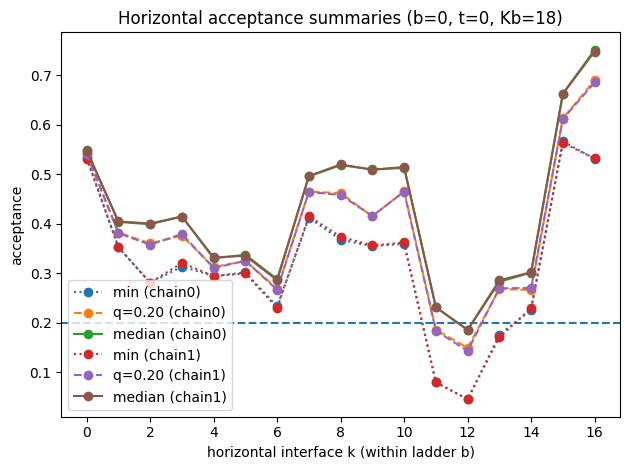

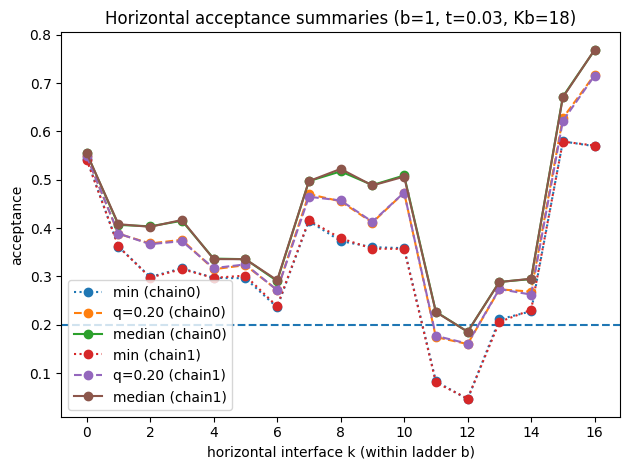

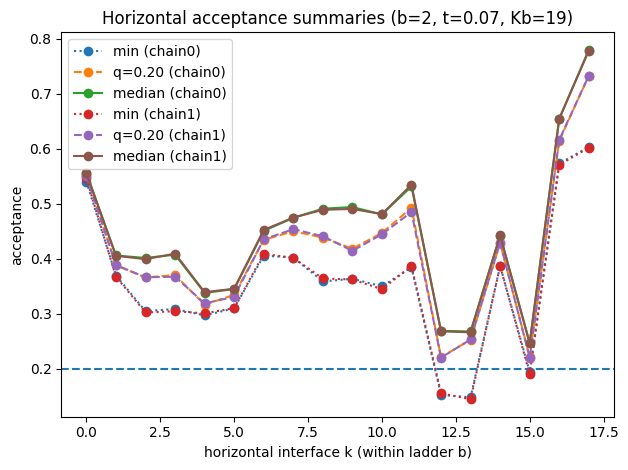

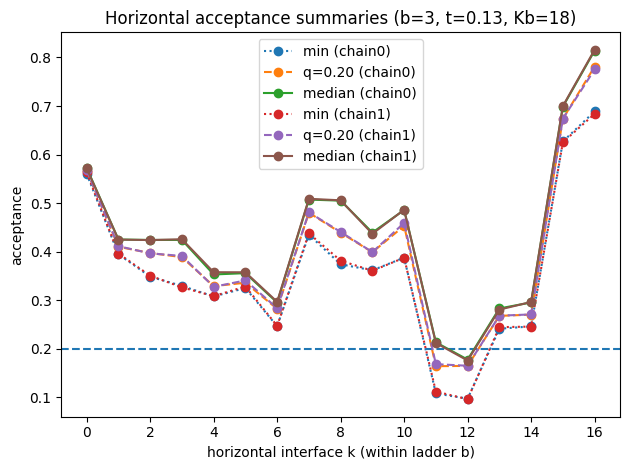

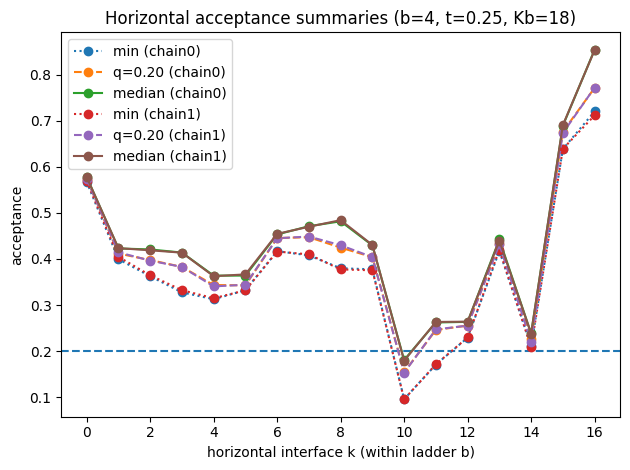

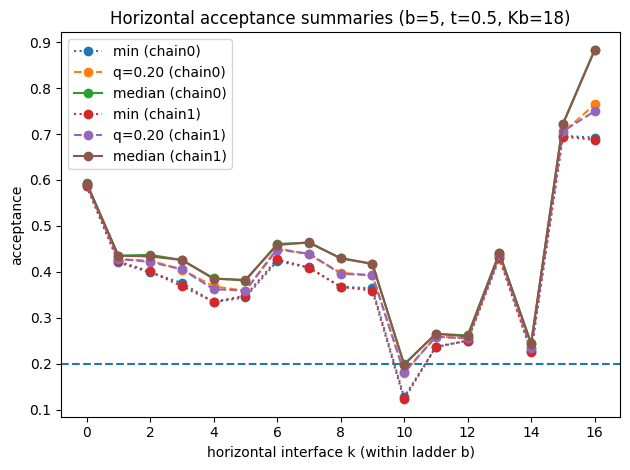

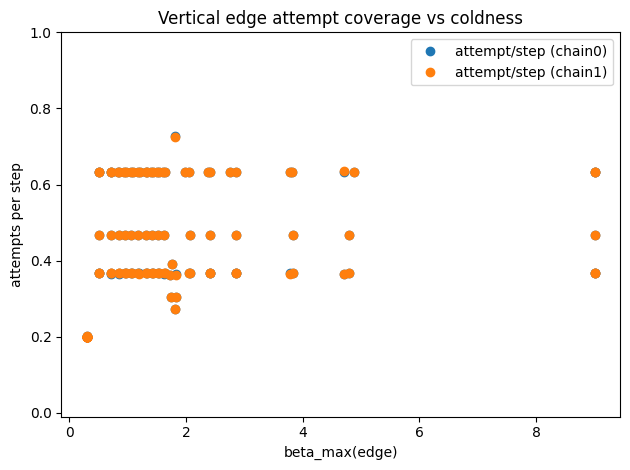

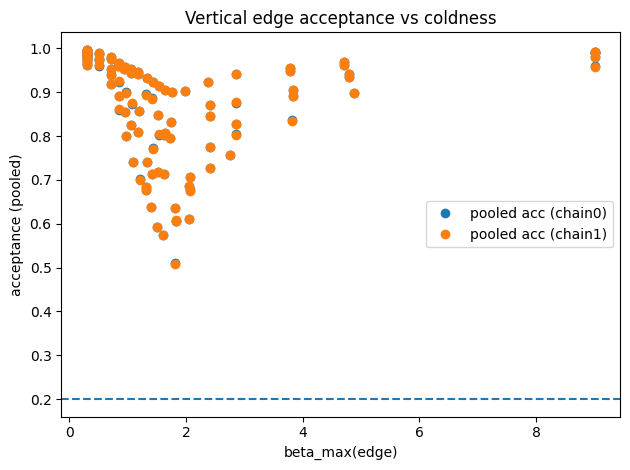

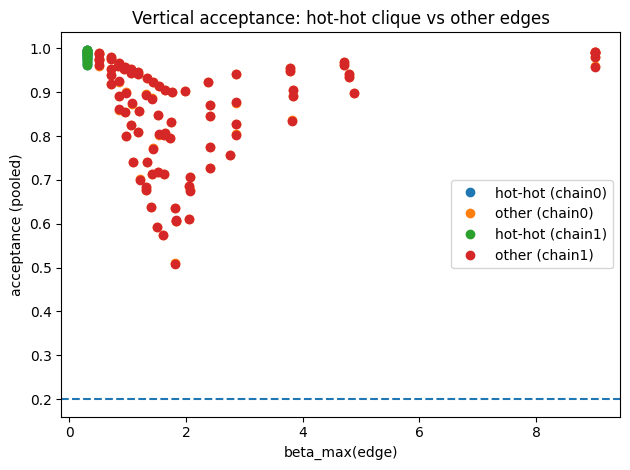

In [38]:
diag = pt2d_acceptance_report(
    sys2,
    results,
    edge_list,
    q_lo=0.20,
    by_chain=True,
    save_prefix=None,   # or "diag2d_" to save pngs
    show=True,
)

In [45]:
att_stack = np.stack([r.attempted_v for r in results], axis=0)  # (R,2,E)
accp_stack = np.stack([r.acc_v for r in results], axis=0)      # (R,2,E)  <-- already a prob

print("attempt range:", att_stack.min(), att_stack.max())
print("acc_prob range:", np.nanmin(accp_stack), np.nanmax(accp_stack))

attempt range: 9715.0 36522.0
acc_prob range: 0.2851435335898195 0.9999045285300576


In [46]:
from matplotlib.collections import LineCollection

def edge_meta(sys, edge_list: np.ndarray):
    """
    Returns dict with per-edge metadata:
      r1,r2, b1,b2, t1,t2, beta1,beta2, dt, beta_mid, beta_max
    """
    edge_list = np.ascontiguousarray(edge_list, dtype=np.int64)
    r1 = edge_list[:, 0]
    r2 = edge_list[:, 1]

    b1 = sys.b_of_r[r1]
    b2 = sys.b_of_r[r2]

    t1 = sys.t_grid[b1].astype(np.float64, copy=False)
    t2 = sys.t_grid[b2].astype(np.float64, copy=False)

    beta1 = sys.beta[r1].astype(np.float64, copy=False)
    beta2 = sys.beta[r2].astype(np.float64, copy=False)

    dt = np.abs(t2 - t1)
    beta_mid = 0.5 * (beta1 + beta2)
    beta_max = np.maximum(beta1, beta2)

    return dict(
        r1=r1, r2=r2,
        b1=b1, b2=b2,
        t1=t1, t2=t2,
        beta1=beta1, beta2=beta2,
        dt=dt, beta_mid=beta_mid, beta_max=beta_max,
    )
def plot_edge_graph_tbeta(sys, edge_list, attempted_v, accepted_v, *,
                          rid=0, chain=0, min_attempts=1, title=None):
    """
    Plots the vertical edges as line segments in (t, beta) coordinates for one disorder.
    Color = per-edge acceptance for that disorder+chain.
    """
    meta = edge_meta(sys, edge_list)
    E = edge_list.shape[0]

    att = attempted_v[rid, chain].astype(np.float64)
    acc = accepted_v[rid, chain].astype(np.float64)

    a = np.full(E, np.nan, dtype=np.float64)
    m = att >= float(min_attempts)
    a[m] = acc[m] 

    # segments: [(t1,b1)->(t2,b2)]
    segs = np.stack(
        [np.stack([meta["t1"], meta["beta1"]], axis=1),
         np.stack([meta["t2"], meta["beta2"]], axis=1)],
        axis=1
    )

    lc = LineCollection(segs, array=a)  # default colormap
    fig, ax = plt.subplots(figsize=(7.5, 4.5))
    ax.add_collection(lc)
    ax.autoscale()
    cb = fig.colorbar(lc, ax=ax)
    cb.set_label("acceptance (accepted/attempted)")

    ax.set_xlabel("t")
    ax.set_ylabel("beta")
    ax.set_title(title or f"Vertical graph in (t,beta): rid={rid}, chain={chain}")
    plt.tight_layout()
    plt.yscale('log')
    plt.show()
def plot_vertical_attempt_coverage(sys, edge_list, attempted_v, *, chain=None, min_attempts=1):
    """
    Shows (i) fraction of disorders where an edge is attempted at least min_attempts,
         (ii) a few quantiles of attempt counts across disorders.
    """
    meta = edge_meta(sys, edge_list)
    A = attempted_v.astype(np.float64)  # (Rtot, 2, E)

    if chain is None:
        A_use = A.mean(axis=1)          # (Rtot, E)
        label = "avg chains"
    else:
        A_use = A[:, int(chain), :]     # (Rtot, E)
        label = f"chain {chain}"

    cov = np.mean(A_use >= float(min_attempts), axis=0)  # (E,)
    q10 = np.quantile(A_use, 0.10, axis=0)
    q50 = np.quantile(A_use, 0.50, axis=0)
    q90 = np.quantile(A_use, 0.90, axis=0)

    x = meta["beta_max"]

    plt.figure(figsize=(7, 3.8))
    plt.plot(x, cov, marker="o", linestyle="none")
    plt.xlabel("beta_max(edge)")
    plt.ylabel(f"coverage P(att≥{min_attempts}) [{label}]")
    plt.title("Vertical attempt coverage across disorders")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7, 3.8))
    plt.plot(x, q10, marker="o", linestyle="none", label="q10 attempts")
    plt.plot(x, q50, marker="o", linestyle="none", label="median attempts")
    plt.plot(x, q90, marker="o", linestyle="none", label="q90 attempts")
    plt.xlabel("beta_max(edge)")
    plt.ylabel(f"attempt count per edge [{label}]")
    plt.title("Attempt count quantiles across disorders")
    plt.legend()
    plt.tight_layout()
    plt.show()
def plot_vertical_acceptance_quantiles(sys, edge_list, attempted_v, accepted_v, *,
                                      chain=None, q_lo=0.2, min_attempts=1, xaxis="beta_max"):
    """
    For each edge, compute acceptance per disorder (masked if not attempted),
    then plot median + low/high quantiles across disorders.
    """
    meta = edge_meta(sys, edge_list)
    att = attempted_v.astype(np.float64)   # (Rtot,2,E)
    acc = accepted_v.astype(np.float64)

    if chain is None:
        att = att.mean(axis=1)            # (Rtot,E)
        acc = acc.mean(axis=1)
        label = "avg chains"
    else:
        att = att[:, int(chain), :]
        acc = acc[:, int(chain), :]
        label = f"chain {chain}"

    A = np.full_like(acc, np.nan, dtype=np.float64)  # (Rtot,E)
    m = att >= float(min_attempts)
    A[m] = acc[m] / att[m]

    med = np.nanquantile(A, 0.50, axis=0)
    lo  = np.nanquantile(A, q_lo, axis=0)
    hi  = np.nanquantile(A, 1.0 - q_lo, axis=0)

    x = meta[xaxis] if xaxis in meta else meta["beta_max"]

    plt.figure(figsize=(7.2, 4.0))
    plt.plot(x, med, marker="o", linestyle="none", label="median")
    plt.plot(x, lo,  marker="o", linestyle="none", label=f"q={q_lo:.2f}")
    plt.plot(x, hi,  marker="o", linestyle="none", label=f"q={1-q_lo:.2f}")
    plt.axhline(0.2, linestyle="--")
    plt.xlabel(xaxis)
    plt.ylabel(f"acceptance quantiles [{label}]")
    plt.title("Vertical acceptance across disorders (edge-wise quantiles)")
    plt.legend()
    plt.tight_layout()
    plt.show()
def heatmap_vertical_acceptance(sys, edge_list, attempted_v, accepted_v, *,
                               chain=None, q=0.5, min_attempts=1,
                               bins_dt=10, bins_beta=15):
    """
    Bin edges by (dt, beta_mid). In each bin, take nan-quantile q over disorders,
    using per-disorder acceptance values for edges in that bin.
    """
    meta = edge_meta(sys, edge_list)
    dt = meta["dt"]
    bm = meta["beta_mid"]

    att = attempted_v.astype(np.float64)
    acc = accepted_v.astype(np.float64)

    if chain is None:
        att = att.mean(axis=1)
        acc = acc.mean(axis=1)
        label = "avg chains"
    else:
        att = att[:, int(chain), :]
        acc = acc[:, int(chain), :]
        label = f"chain {chain}"

    # per-disorder acceptance (Rtot,E)
    A = np.full_like(acc, np.nan, dtype=np.float64)
    m = att >= float(min_attempts)
    A[m] = acc[m] / att[m]

    dt_edges = np.linspace(dt.min(), dt.max() + 1e-12, int(bins_dt) + 1)
    bm_edges = np.linspace(bm.min(), bm.max() + 1e-12, int(bins_beta) + 1)

    H = np.full((bins_dt, bins_beta), np.nan, dtype=np.float64)

    # loop bins (cheap, E usually not huge)
    for i in range(bins_dt):
        in_dt = (dt >= dt_edges[i]) & (dt < dt_edges[i+1])
        for j in range(bins_beta):
            in_bm = (bm >= bm_edges[j]) & (bm < bm_edges[j+1])
            idx = np.where(in_dt & in_bm)[0]
            if idx.size == 0:
                continue
            # pool across edges in this bin, but quantile over disorders:
            # first average acceptance across edges per disorder (robust to huge edge counts)
            a_bin = np.nanmean(A[:, idx], axis=1)  # (Rtot,)
            H[i, j] = np.nanquantile(a_bin, q)

    plt.figure(figsize=(7.5, 4.5))
    plt.imshow(H, aspect="auto", origin="lower",
               extent=[bm_edges[0], bm_edges[-1], dt_edges[0], dt_edges[-1]])
    plt.colorbar(label=f"quantile_{q} acceptance [{label}]")
    plt.xlabel("beta_mid(edge)")
    plt.ylabel("dt(edge) = |t2-t1|")
    plt.title("Vertical acceptance summary in (dt, beta_mid) bins")
    plt.tight_layout()
    plt.show()


attempted_v: (30, 2, 102) accepted_v: (30, 2, 102) E: 102


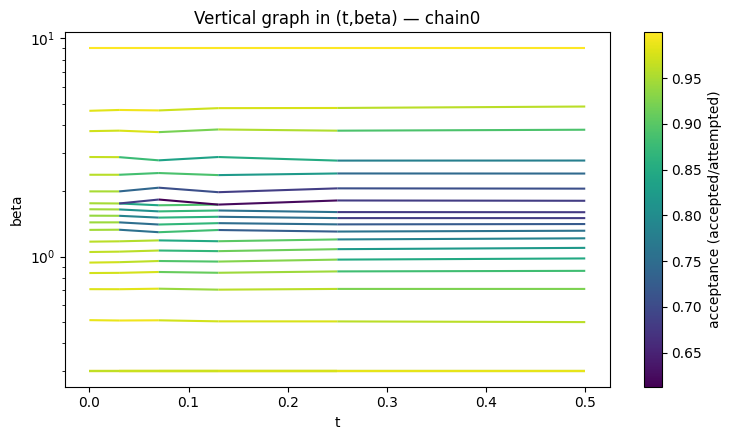

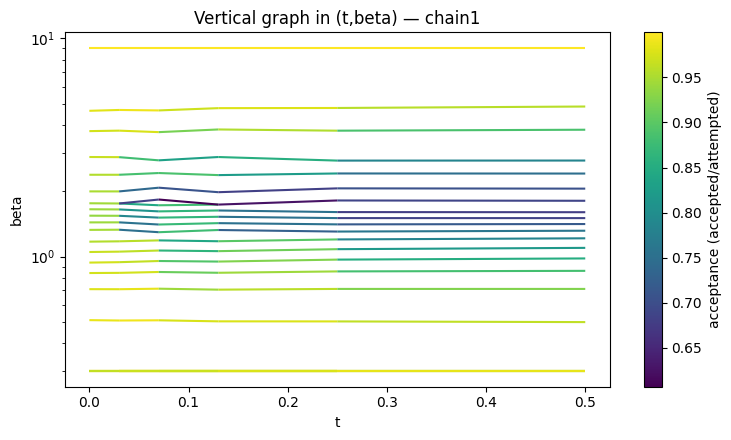

In [50]:
# Assumes you already have:
#   results   : list[TrialResult] from pool_orchestrator_stats(...)
#   sys2      : SysConfig
#   edge_list : (E,2) int64
#
# and each TrialResult has:
#   .attemped_v : (2,E) float/int
#   .acc_v      : (2,E) float/int   (this should be ACCEPTED COUNTS, not acceptance prob)
# If your .acc_v is already acceptance prob, DO NOT use it here; store accepted counts instead.

import numpy as np

# ----------------------------
# 0) stack arrays from results
# ----------------------------
attempted_v = np.stack([r.attempted_v for r in results], axis=0)   # (Rtot,2,E)
accepted_v  = np.stack([r.acc_v      for r in results], axis=0)   # (Rtot,2,E)

print("attempted_v:", attempted_v.shape, "accepted_v:", accepted_v.shape, "E:", edge_list.shape[0])

# ----------------------------
# 1) pick a disorder to inspect
# ----------------------------
rid0 = 3  # or: np.random.randint(attempted_v.shape[0])

# choose chain=None to average chains, or chain=0/1
chain_to_use = None

# ----------------------------
# 2) run all diagnostics
# ----------------------------
plot_edge_graph_tbeta(sys2, edge_list, attempted_v, accepted_v,
                      rid=rid0, chain=0, min_attempts=1,
                      title="Vertical graph in (t,beta) — chain0")

plot_edge_graph_tbeta(sys2, edge_list, attempted_v, accepted_v,
                      rid=rid0, chain=1, min_attempts=1,
                      title="Vertical graph in (t,beta) — chain1")


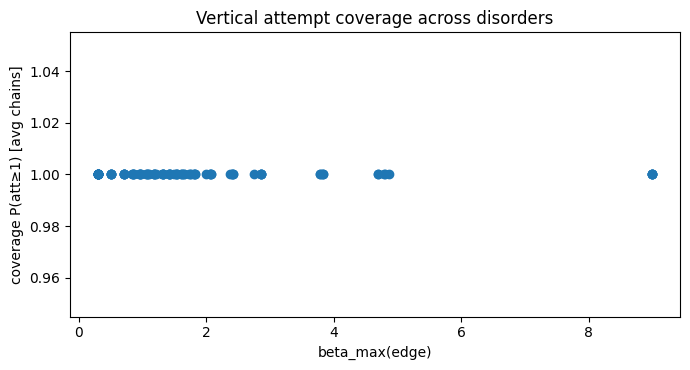

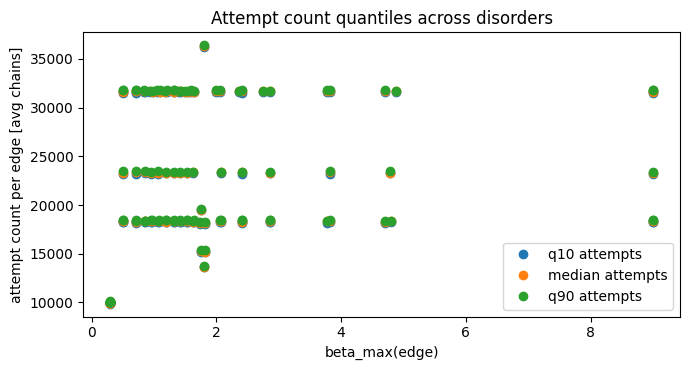

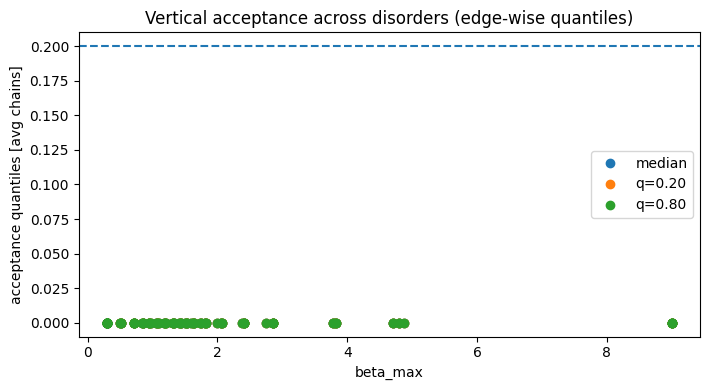

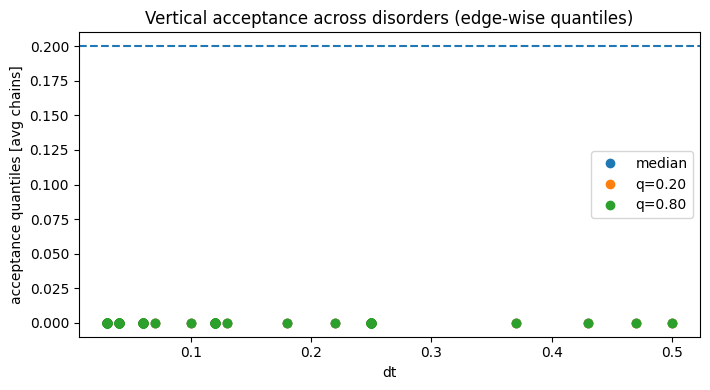

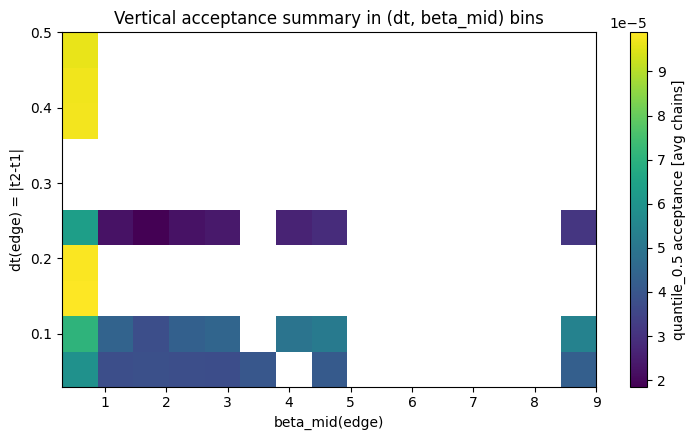

In [51]:

plot_vertical_attempt_coverage(sys2, edge_list, attempted_v,
                               chain=chain_to_use, min_attempts=1)

plot_vertical_acceptance_quantiles(sys2, edge_list, attempted_v, accepted_v,
                                   chain=chain_to_use, q_lo=0.2, min_attempts=1,
                                   xaxis="beta_max")

plot_vertical_acceptance_quantiles(sys2, edge_list, attempted_v, accepted_v,
                                   chain=chain_to_use, q_lo=0.2, min_attempts=1,
                                   xaxis="dt")

heatmap_vertical_acceptance(sys2, edge_list, attempted_v, accepted_v,
                            chain=chain_to_use, q=0.5, min_attempts=1,
                            bins_dt=10, bins_beta=15)


In [28]:
k_start

array([  0.,  18.,  36.,  55.,  73.,  91., 109.])

In [21]:
beta_by_t

[array([0.3       , 0.51114647, 0.70886339, 0.84042964, 0.93836619,
        1.04940056, 1.17048405, 1.32547126, 1.43459809, 1.53980174,
        1.64759751, 1.75539329, 1.98994856, 2.37187008, 2.86058918,
        3.75984102, 4.65909286, 9.        ]),
 array([0.3       , 0.50912175, 0.70839226, 0.84202731, 0.94246199,
        1.05333342, 1.17456485, 1.32779503, 1.43498867, 1.53799925,
        1.64476135, 1.75152346, 1.98940656, 2.37165984, 2.85653072,
        3.7786246 , 4.70071848, 9.        ]),
 array([0.3       , 0.51023428, 0.71240895, 0.84975135, 0.95422111,
        1.06594571, 1.18626929, 1.29326174, 1.4027393 , 1.50872165,
        1.61138679, 1.71871686, 1.82604694, 2.06916518, 2.41549201,
        2.76181884, 3.71983259, 4.67784635, 9.        ]),
 array([0.3       , 0.50468242, 0.70519414, 0.84274581, 0.94862238,
        1.05887614, 1.17560016, 1.32358983, 1.42308642, 1.52212004,
        1.62661575, 1.73111146, 1.97306635, 2.36314232, 2.86028063,
        3.82613308, 4.79198554, 9.

In [18]:
beta_flat = np.array([])
for i in range (len(t_grid)):
    beta_flat = np.append(beta_flat,my_res[i][0])

In [19]:
beta_flat

array([0.3       , 0.51114647, 0.70886339, 0.84042964, 0.93836619,
       1.04940056, 1.17048405, 1.32547126, 1.43459809, 1.53980174,
       1.64759751, 1.75539329, 1.98994856, 2.37187008, 2.86058918,
       3.75984102, 4.65909286, 9.        , 0.3       , 0.50912175,
       0.70839226, 0.84202731, 0.94246199, 1.05333342, 1.17456485,
       1.32779503, 1.43498867, 1.53799925, 1.64476135, 1.75152346,
       1.98940656, 2.37165984, 2.85653072, 3.7786246 , 4.70071848,
       9.        , 0.3       , 0.51023428, 0.71240895, 0.84975135,
       0.95422111, 1.06594571, 1.18626929, 1.29326174, 1.4027393 ,
       1.50872165, 1.61138679, 1.71871686, 1.82604694, 2.06916518,
       2.41549201, 2.76181884, 3.71983259, 4.67784635, 9.        ,
       0.3       , 0.50468242, 0.70519414, 0.84274581, 0.94862238,
       1.05887614, 1.17560016, 1.32358983, 1.42308642, 1.52212004,
       1.62661575, 1.73111146, 1.97306635, 2.36314232, 2.86028063,
       3.82613308, 4.79198554, 9.        , 0.3       , 0.50427

In [7]:
def pt_diagnostics_report(
    I_ts_stack,
    betas=None,
    acc_stack=None,
    *,
    q_lo=0.20,                  # disorder-guard quantile for acceptance summaries
    burn_in=0,                  # int steps, or float fraction in (0,1)
    chains=(0, 1),              # which independent chains to analyze (if present)
    plot_disorders=10,           # how many representative disorders to plot as lines
    trace_walkers=6,            # how many walkers to show in k_w(t) traces
    trace_disorder="worst",     # "worst" | "median" | int disorder index
    trace_chain=0,
    save_prefix=None,           # e.g. "diag_" -> saves diag_*.png
    show=True,
):
    """
    Drop-in PT diagnostics from I_ts (slot->walker time series) and optional acc_stack.

    Expected shapes:
      - I_ts_stack: (R, B, T, K) or (B, T, K) or (T, K)
      - acc_stack : (R, K-1) or (K-1,) (optional)

    Returns a dict of computed metrics (arrays are numpy).
    Produces plots (matplotlib) unless show=False.
    """


    # ---------- normalize input shapes ----------
    I = np.asarray(I_ts_stack)
    if I.ndim == 4:
        R, B, T, K = I.shape
    elif I.ndim == 3:
        R = 1
        B, T, K = I.shape
        I = I[None, ...]
    elif I.ndim == 2:
        R = 1
        B = 1
        T, K = I.shape
        I = I[None, None, ...]
    else:
        raise ValueError("I_ts_stack must have shape (R,B,T,K), (B,T,K), or (T,K).")

    if betas is None:
        beta = None
    else:
        beta = np.asarray(betas, float)
        if beta.shape[0] != K:
            raise ValueError(f"betas length {beta.shape[0]} does not match K={K}.")

    # burn-in
    if isinstance(burn_in, float):
        if not (0.0 <= burn_in < 1.0):
            raise ValueError("burn_in as float must be in [0,1).")
        t0 = int(np.floor(burn_in * T))
    else:
        t0 = int(burn_in)
    t0 = max(0, min(t0, T - 1))
    Teff = T - t0

    temperatures = np.sort(1/np.asarray(betas))


    # chains to analyze
    chains = tuple(int(c) for c in chains)
    for c in chains:
        if not (0 <= c < B):
            raise ValueError(f"chain index {c} out of range for B={B}.")

    hot_k, cold_k = 0, K - 1

    # ---------- helpers ----------
    def _roundtrips_from_ends(w_hot, w_cold, K):
        """
        Hot-based round trips: hot->cold->hot for each walker.
        Returns (rt_times list, n_rt, rt_rate).
        """
        t_hot_start = np.full(K, -1, dtype=np.int64)
        seen_cold   = np.zeros(K, dtype=np.bool_)
        rts = []

        for t in range(w_hot.shape[0]):
            wh = int(w_hot[t])
            wc = int(w_cold[t])

            # cold visit marks success-in-between if a hot-start exists
            if t_hot_start[wc] != -1:
                seen_cold[wc] = True

            # hot visit closes a round trip if cold was seen
            if t_hot_start[wh] != -1 and seen_cold[wh]:
                rts.append(t - t_hot_start[wh])

            # (re)start from hot
            t_hot_start[wh] = t
            seen_cold[wh] = False

        n_rt = len(rts)
        rt_rate = n_rt / max(1, w_hot.shape[0])
        return rts, n_rt, rt_rate

    def _passages_from_ends(w_hot, w_cold, K):
        """
        One-way end-to-end passage times:
          - hot->cold and cold->hot, using "last end visited" timestamps per walker.
        Returns two lists: tau_hc, tau_ch.
        """
        last_end = np.zeros(K, dtype=np.int8)     # 0 none, +1 hot, -1 cold
        last_t   = np.full(K, -1, dtype=np.int64)

        tau_hc = []
        tau_ch = []

        for t in range(w_hot.shape[0]):
            wh = int(w_hot[t])
            wc = int(w_cold[t])

            # cold hit
            if last_end[wc] == +1:
                tau_hc.append(t - last_t[wc])
            last_end[wc] = -1
            last_t[wc] = t

            # hot hit
            if last_end[wh] == -1:
                tau_ch.append(t - last_t[wh])
            last_end[wh] = +1
            last_t[wh] = t

        return tau_hc, tau_ch

    def _flow_profile_f(I_bt):
        """
        Directional flow profile f(k) from one chain:
        I_bt: (Teff, K) slot->walker.
        Implements:
          label walker by last end visited: +1 (hot), -1 (cold), 0 unknown.
          f(k) = P(label=+1 | at slot k), estimated over time, excluding unknown labels.
        Returns:
          f: (K,) with NaNs possible if denom=0 at a slot (unlikely)
          denom: (K,) number of labeled samples accumulated at each slot
        """
        labels = np.zeros(K, dtype=np.int8)  # per walker: 0 unknown, +1 hot, -1 cold
        num = np.zeros(K, dtype=np.float64)
        den = np.zeros(K, dtype=np.float64)

        for t in range(I_bt.shape[0]):
            wh = int(I_bt[t, hot_k])
            wc = int(I_bt[t, cold_k])
            labels[wh] = +1
            labels[wc] = -1

            lab_slots = labels[I_bt[t]]  # (K,)
            known = (lab_slots != 0)
            den[known] += 1.0
            num[known] += (lab_slots[known] == +1)

        f = np.full(K, np.nan, dtype=np.float64)
        mask = den > 0
        f[mask] = num[mask] / den[mask]
        return f, den

    def _invert_perm(I_t):
        """Given I_t (K,) slot->walker, return k_of_w (K,) walker->slot."""
        k_of_w = np.empty(K, dtype=np.int16)
        k_of_w[I_t.astype(np.int64)] = np.arange(K, dtype=np.int16)
        return k_of_w

    def _backtracking_rho1(I_bt, walkers=None):
        """
        Backtracking correlation rho1 = Corr(delta k(t), delta k(t+1)) for selected walkers,
        where k_w(t) is walker position (slot index).
        Returns:
          rho_w: (len(walkers),) rho1 per walker (NaN if too few moves)
          rho_med: median rho1 ignoring NaNs
        """
        Te = I_bt.shape[0]
        if walkers is None:
            walkers = np.arange(K, dtype=np.int64)
        else:
            walkers = np.asarray(walkers, dtype=np.int64)

        # build k_w(t) for selected walkers only, streaming
        k_prev = _invert_perm(I_bt[0])[walkers].astype(np.int16)
        dk_prev = None
        xs = [[] for _ in range(walkers.size)]
        ys = [[] for _ in range(walkers.size)]

        for t in range(1, Te):
            k_now = _invert_perm(I_bt[t])[walkers].astype(np.int16)
            dk = (k_now - k_prev).astype(np.int16)
            if dk_prev is not None:
                for i in range(walkers.size):
                    xs[i].append(int(dk_prev[i]))
                    ys[i].append(int(dk[i]))
            dk_prev = dk
            k_prev = k_now

        rho = np.full(walkers.size, np.nan, dtype=np.float64)
        for i in range(walkers.size):
            x = np.array(xs[i], dtype=np.float64)
            y = np.array(ys[i], dtype=np.float64)
            if x.size >= 10 and np.std(x) > 0 and np.std(y) > 0:
                rho[i] = np.corrcoef(x, y)[0, 1]
        rho_med = np.nanmedian(rho)
        return rho, rho_med

    # ---------- compute per-disorder, per-chain metrics ----------
    rt_count = np.zeros((R, B), dtype=np.int64)
    rt_rate  = np.zeros((R, B), dtype=np.float64)
    rt_med   = np.full((R, B), np.nan, dtype=np.float64)

    tau_hc_med = np.full((R, B), np.nan, dtype=np.float64)
    tau_ch_med = np.full((R, B), np.nan, dtype=np.float64)

    f_prof = np.full((R, B, K), np.nan, dtype=np.float64)
    f_slope_max = np.full((R, B), np.nan, dtype=np.float64)

    rho1_med = np.full((R, B), np.nan, dtype=np.float64)

    for r in range(R):
        for b in chains:
            I_bt = I[r, b, t0:, :].astype(np.int64)  # (Teff,K)
            w_hot  = I_bt[:, hot_k]
            w_cold = I_bt[:, cold_k]

            rts, nrt, rate = _roundtrips_from_ends(w_hot, w_cold, K)
            rt_count[r, b] = nrt
            rt_rate[r, b]  = rate
            if rts:
                rt_med[r, b] = float(np.median(np.array(rts, dtype=np.int64)))

            tau_hc, tau_ch = _passages_from_ends(w_hot, w_cold, K)
            if tau_hc:
                tau_hc_med[r, b] = float(np.median(np.array(tau_hc, dtype=np.int64)))
            if tau_ch:
                tau_ch_med[r, b] = float(np.median(np.array(tau_ch, dtype=np.int64)))

            f, _den = _flow_profile_f(I_bt)
            f_prof[r, b, :] = f
            if np.all(np.isnan(f)):
                f_slope_max[r, b] = np.nan
            else:
                df = np.diff(f)
                f_slope_max[r, b] = np.nanmax(np.abs(df))

            # backtracking correlation on a small subset of walkers (cheap + informative)
            walkers = np.linspace(0, K - 1, min(trace_walkers, K), dtype=np.int64)
            _rho, rho_med_val = _backtracking_rho1(I_bt, walkers=walkers)
            rho1_med[r, b] = rho_med_val

    # ---------- acceptance aggregation (optional) ----------
    acc_summary = None
    if acc_stack is not None:
        A = np.asarray(acc_stack, float)
        if A.ndim == 1:
            if A.shape[0] != K - 1:
                raise ValueError("acc_stack length must be K-1.")
            acc_med = A.copy()
            acc_lo  = A.copy()
            acc_hi  = A.copy()
        elif A.ndim == 2:
            if A.shape[1] != K - 1:
                raise ValueError("acc_stack must have shape (R,K-1).")
            acc_med = np.quantile(A, 0.50, axis=0)
            acc_lo  = np.quantile(A, q_lo, axis=0)
            acc_hi  = np.quantile(A, 1.0 - q_lo, axis=0)
        else:
            raise ValueError("acc_stack must be shape (K-1,) or (R,K-1).")

        acc_summary = dict(acc_med=acc_med, acc_lo=acc_lo, acc_hi=acc_hi)

    # ---------- choose representative disorders ----------
    # Use median over analyzed chains of rt_rate to rank disorders
    rt_rate_used = np.nanmedian(rt_rate[:, list(chains)], axis=1)
    worst_r = int(np.nanargmin(rt_rate_used))
    best_r  = int(np.nanargmax(rt_rate_used))
    med_r   = int(np.argsort(rt_rate_used)[len(rt_rate_used)//2]) if R > 1 else 0

    if trace_disorder == "worst":
        trace_r = worst_r
    elif trace_disorder == "median":
        trace_r = med_r
    elif isinstance(trace_disorder, int):
        trace_r = int(trace_disorder)
    else:
        raise ValueError("trace_disorder must be 'worst', 'median', or an int index.")

    reps = [worst_r, med_r, best_r]
    reps = reps[:min(plot_disorders, len(reps))]

    # ---------- plots ----------
    figs = []

    # 1) Acceptance per interface (median/low/high quantiles across disorders)
    if acc_summary is not None:
        fig = plt.figure(figsize=(7, 3.8))
        x = np.arange(K - 1)
        plt.axhline(0.2, linestyle="--")
        plt.plot(x,A.min(axis=0), marker="o", linestyle=":", label="acc min")
        plt.plot(x, acc_summary["acc_med"], marker="o", linestyle="-", label="acc median")
        plt.plot(x, acc_summary["acc_lo"],  marker="o", linestyle="--", label=f"acc q={q_lo:.2f}")
        plt.plot(x, acc_summary["acc_hi"],  marker="o", linestyle="--", label=f"acc q={1-q_lo:.2f}")
        plt.xlabel("interface k (between β_k and β_{k+1})")
        plt.ylabel("acceptance")
        plt.title("Swap acceptance summaries across disorder")
        plt.legend()
        plt.tight_layout()
        figs.append(("acceptance", fig))

    # 2) Round-trip rate per disorder (scatter)
    fig = plt.figure(figsize=(7, 3.8))

    rate1 = 100 / max(1, Teff)
    rate2 = 2/ max(1, Teff)
    plt.axhline(rate1, linestyle="--",label=f"{100} round trips")
    plt.axhline(rate2, linestyle="--",label=f"{2} round trips")
    x = np.arange(R)
    for b in chains:
        plt.plot(x, rt_rate[:, b], marker="o", linestyle="none", label=f"chain {b}")
    plt.xlabel("disorder index r")
    plt.ylabel("round trips per step")
    plt.title(f"Round-trip rate (burn-in t0={t0}, Teff={Teff})")
    #plt.yscale("log")
    plt.legend()
    plt.tight_layout()
    figs.append(("rt_rate", fig))

    # 3) Round-trip time median per disorder
    fig = plt.figure(figsize=(7, 3.8))
    for b in chains:
        plt.plot(x, rt_med[:, b], marker="o", linestyle="none", label=f"chain {b}")
    plt.xlabel("disorder index r")
    plt.ylabel("median RT time (steps)")
    plt.title("Median hot→cold→hot round-trip time")
    #plt.yscale("log")
    plt.legend()
    plt.tight_layout()
    figs.append(("rt_median_time", fig))

    order = np.argsort(rt_rate_used)          # worst -> best
    mid = len(order) // 2

    groups = {
        "worst 3": order[:3],
        "median ±1": order[max(0, mid-1):min(len(order), mid+2)],
        "best 3": order[-3:],
    }

    x = np.arange(K)  # slot index; or use beta / (1/beta) if you want later

    fig, axes = plt.subplots(1, 3, figsize=(12, 3.8), sharey=True)
    for ax, (title, idxs) in zip(axes, groups.items()):
        for r in idxs:
            for b in chains:
                ax.plot(x, f_prof[r, b], marker="o", linestyle="-", label=f"r={r}, b={b}")
        ax.set_title(title)
        ax.set_xlabel("slot k (0 hot → K-1 cold)")
    axes[0].set_ylabel("f(k)")
    axes[0].legend(ncol=1, fontsize=8)
    plt.tight_layout()
    figs.append(("flow_groups", fig))


    # 5) Heatmap of f(k) across disorders (one chain)
    if R > 1:
        fig = plt.figure(figsize=(7, 4.2))
        M = f_prof[:, trace_chain, :]
        plt.imshow(M, aspect="auto", interpolation="nearest")
        plt.colorbar(label="f(k)")
        plt.xlabel("temperature slot k")
        plt.ylabel("disorder index r")
        plt.title(f"f(k) heatmap across disorders (chain {trace_chain})")
        plt.tight_layout()
        figs.append(("flow_heatmap", fig))

    # 6) Walker traces k_w(t) for a few walkers in a chosen disorder
    # This is where k_ts matters: for visualization/debug of "bouncing"/plateaus.
    fig = plt.figure(figsize=(7, 4.2))
    I_bt = I[trace_r, trace_chain, t0:, :].astype(np.int64)
    Te = I_bt.shape[0]
    walkers = np.linspace(0, K - 1, min(trace_walkers, K), dtype=np.int64)

    # build k_w(t) for selected walkers
    k_tr = np.empty((Te, walkers.size), dtype=np.int16)
    for t in range(Te):
        k_of_w = _invert_perm(I_bt[t])
        k_tr[t, :] = k_of_w[walkers]

    t_axis = np.arange(Te)
    for i, w in enumerate(walkers):
        plt.plot(t_axis, k_tr[:, i], linestyle="-", label=f"w={int(w)}")
    plt.xlabel("time step (post burn-in)")
    plt.ylabel("temperature slot k_w(t)")
    plt.title(f"Walker temperature trajectories (r={trace_r}, chain={trace_chain})")
    plt.legend(ncol=2, fontsize=8)
    plt.tight_layout()
    figs.append(("walker_traces", fig))

    # 7) Backtracking (rho1) per disorder
    fig = plt.figure(figsize=(7, 3.8))
    for b in chains:
        plt.plot(np.arange(R), rho1_med[:, b], marker="o", linestyle="none", label=f"chain {b}")
    plt.axhline(0.0, linestyle="--")
    plt.xlabel("disorder index r")
    plt.ylabel("median ρ₁ over sampled walkers")
    plt.title("Backtracking indicator: Corr(Δk(t), Δk(t+1))")
    plt.legend()
    plt.tight_layout()
    figs.append(("backtracking", fig))

    # ---------- save / show ----------
    if save_prefix is not None:
        for name, fig in figs:
            fig.savefig(f"{save_prefix}{name}.png", dpi=150)

    if show:
        plt.show()
    else:
        # avoid GUI side effects; caller can manage figures
        pass

    # ---------- return metrics ----------
    out = dict(
        shape=dict(R=R, B=B, T=T, K=K, burn_in=t0, Teff=Teff),
        betas=beta,
        acc_summary=acc_summary,
        rt_count=rt_count,
        rt_rate=rt_rate,
        rt_med=rt_med,
        tau_hc_med=tau_hc_med,
        tau_ch_med=tau_ch_med,
        f_profile=f_prof,
        f_slope_max=f_slope_max,
        rho1_med=rho1_med,
        representative=dict(worst=worst_r, median=med_r, best=best_r, trace=trace_r),
    )
    return out


In [16]:
sys1  = SysConfig_1d(N=N, P=P, K=betas1.size, t=0.,c=0, β=betas1,
                  mu_to_store=np.array([0]), #useless parameter
                  master_seed=12345, spin_init_mode="random")

trial1 = TrialConfig_1d(equilibration_time=6000, sweeps_per_sample=20, n_samples=1000)


results = pool_orchestrator_stats_1d(sys1, trial1, R_workers=10, R_total=10, start_method="fork")

acc_stack1   = np.stack([r.acc_edge for r in results], axis=0)  # (R, K-1)
I_ts_stack1  = np.stack([r.I_ts for r in results], axis=0)      # (R, B, T, K)

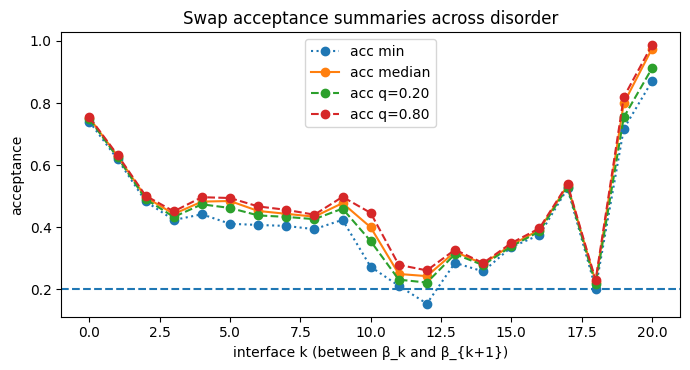

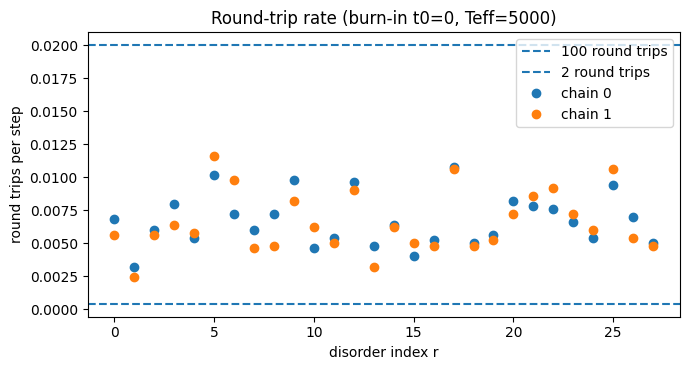

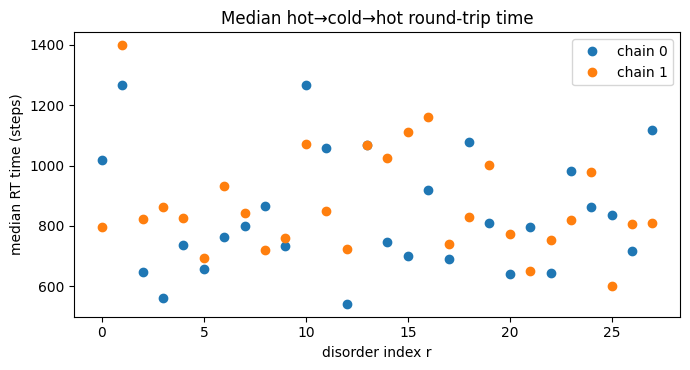

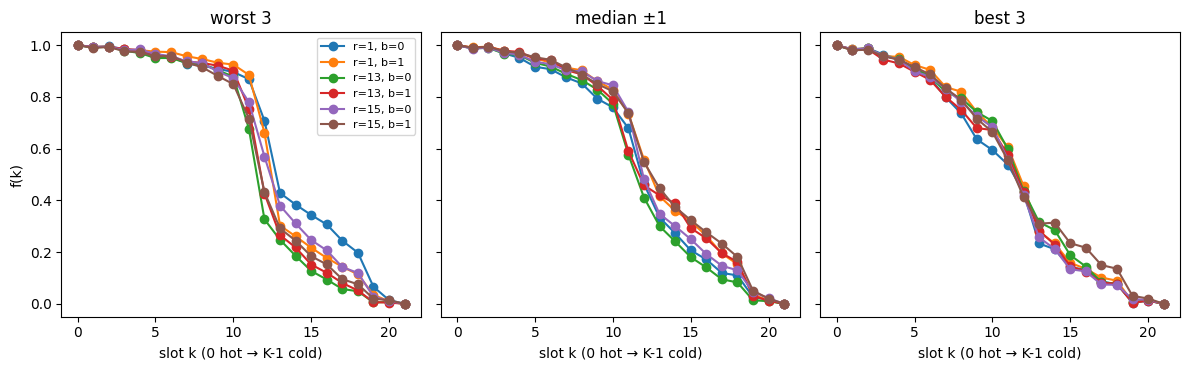

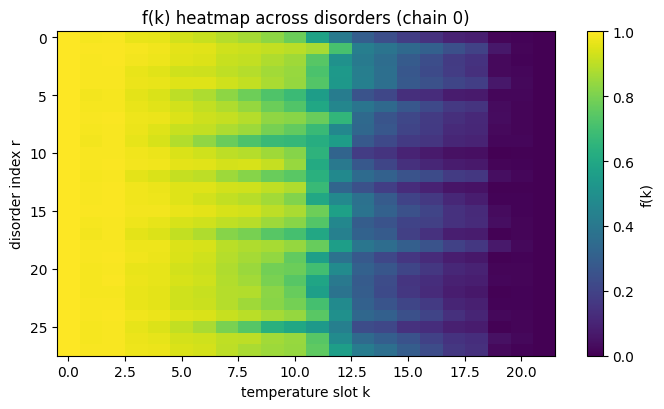

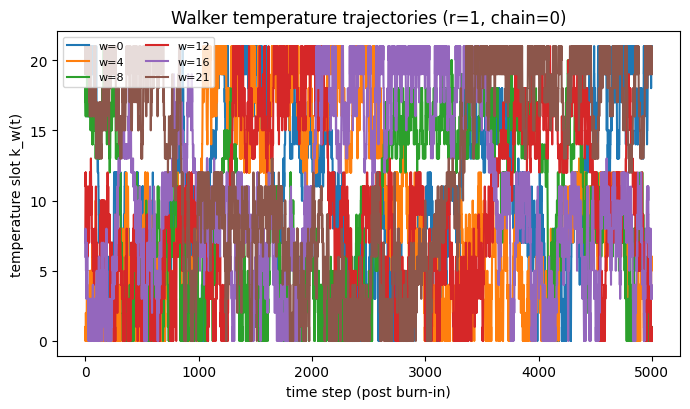

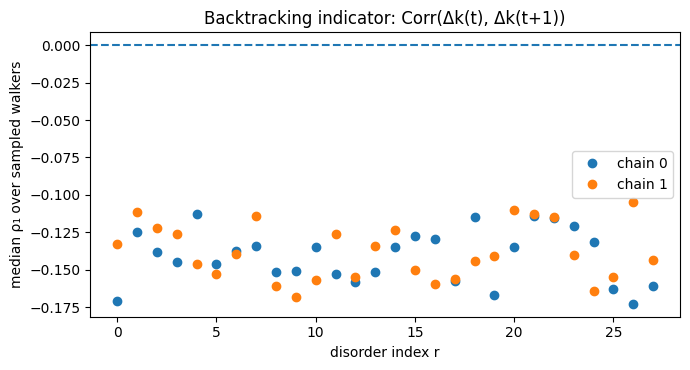

In [8]:
out=pt_diagnostics_report(
    I_ts_stack1,
    betas1,
    acc_stack1)

In [9]:
def refine_ladder(
    sys_template,                  # SysConfig without β fixed
    beta_proposed: np.ndarray,      # 1D array (K,)
    trial,                          # TrialConfig
    R_workers: int, R_total: int,   # pool knobs (disorders)
    A_low=0.20,
    eps=0.01,                      # hysteresis margin
    max_insert=4,
    K_max=64, max_passes=2, verbose=True, start_method="fork"
):
    """
    Refine a proposed ladder by inserting at the WORST interface across disorders:
        acc_min[k] = min_r acc_stack[r,k]
    until acc_min[k] >= A_low - 2*eps for all k, or until limits are reached.

    Returns: (betas, acc_stack, I_ts_stack) from the last evaluation.
    """

    betas = np.asarray(beta_proposed, float).copy()
    inserts = 0

    last_acc_stack = None
    last_I_ts_stack = None

    thr = A_low - 2.0 * eps

    for p in range(1, max_passes + 1):
        sys = replace(sys_template, K=betas.size, β=betas)

        results = pool_orchestrator_stats_1d(
            sys, trial,
            R_workers=R_workers, R_total=R_total,
            start_method=start_method
        )

        acc_stack  = np.stack([r.acc_edge for r in results], axis=0)  # (R_total, K-1)
        I_ts_stack = np.stack([r.I_ts     for r in results], axis=0)  # (R_total, B, T, K)

        last_acc_stack = acc_stack
        last_I_ts_stack = I_ts_stack

        acc_min = acc_stack.min(axis=0)            # (K-1,)
        k_worst = int(np.argmin(acc_min))
        a_worst = float(acc_min[k_worst])

        if verbose:
            print(f"\nrefine pass {p:2d} | K={betas.size:2d} | "
                  f"worst acc_min={a_worst:.4f} at iface {k_worst} | thr={thr:.4f}")

        # success: no single “doomed” interface remains
        if a_worst >= thr:
            if verbose: print("→ refine done (all acc_min above threshold)")
            return betas, acc_stack, I_ts_stack

        # cannot insert further
        if betas.size >= K_max:
            if verbose: print("→ refine stopped (reached K_max)")
            return betas, acc_stack, I_ts_stack

        if inserts >= max_insert:
            if verbose: print("→ refine stopped (reached max_insert)")
            return betas, acc_stack, I_ts_stack

        # insert midpoint at the *current* worst interface
        betas = np.insert(betas, k_worst + 1, 0.5 * (betas[k_worst] + betas[k_worst + 1]))
        inserts += 1
        if verbose: print(f"＋ insert after iface {k_worst}  -> K={betas.size}")

    if verbose: print("→ refine stopped (reached max_passes)")
    return betas, last_acc_stack, last_I_ts_stack

In [10]:
trial1 = TrialConfig_1d(equilibration_time=6000, sweeps_per_sample=50, n_samples=1000)
betas1, acc_stack1, I_ts_stack1 = refine_ladder(
    sys0,                  # SysConfig without β fixed
    betas1,      # 1D array (K,)
    trial1,                          # TrialConfig
    R_workers=14, R_total=28,   # pool knobs (disorders)
    A_low=0.15,
    eps=0.01,                      # hysteresis margin
    max_insert=5,
    K_max=64, max_passes=7, verbose=True, start_method="spawn"
)


refine pass  1 | K=22 | worst acc_min=0.1537 at iface 12 | thr=0.1300
→ refine done (all acc_min above threshold)


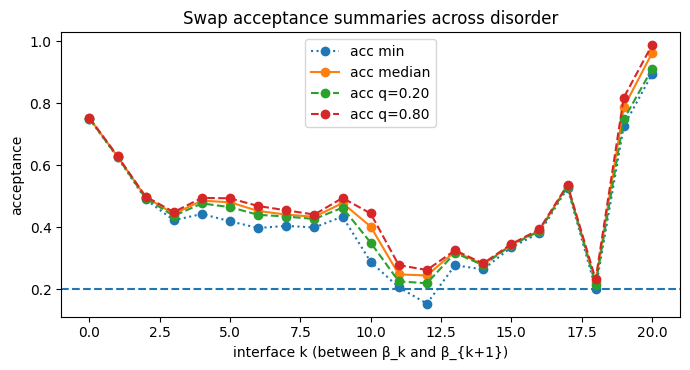

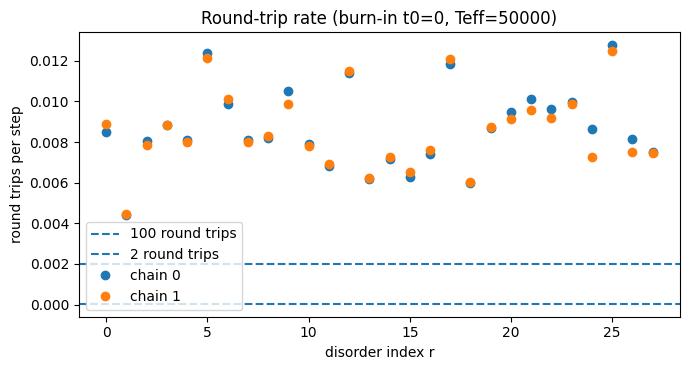

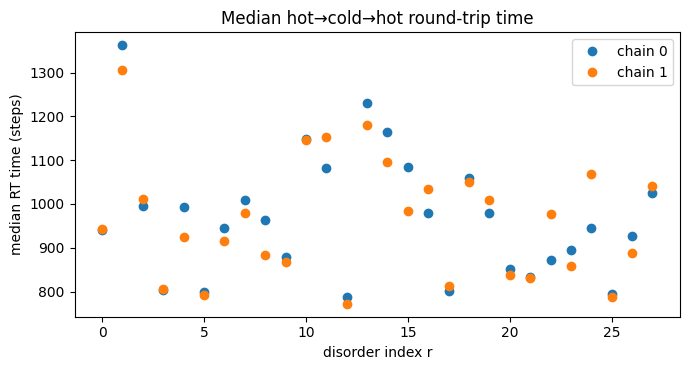

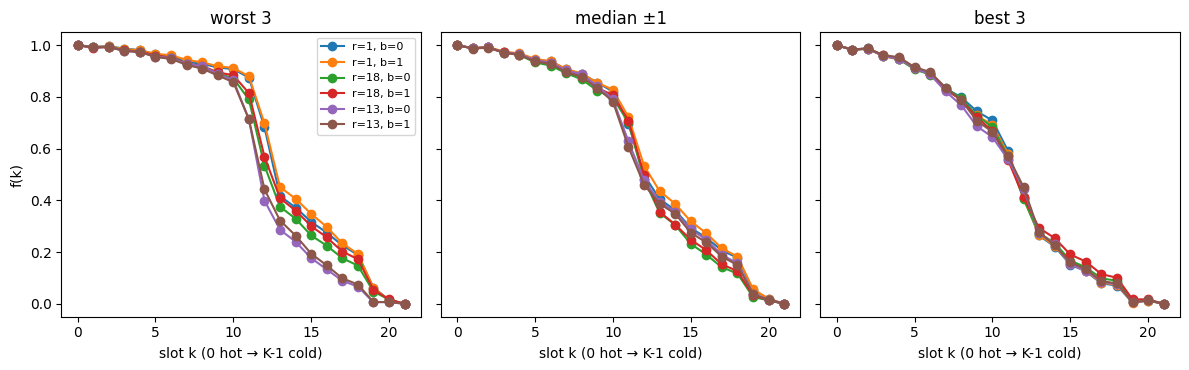

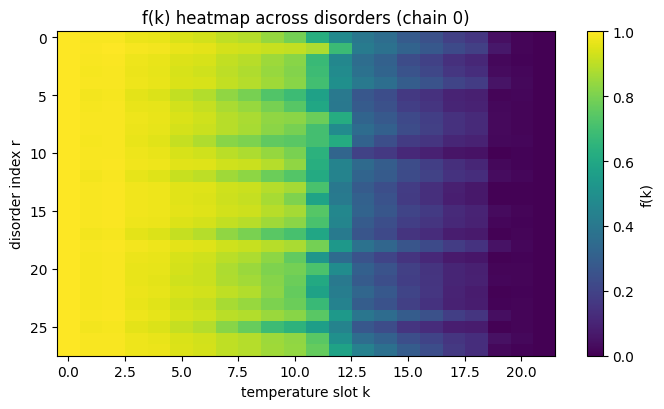

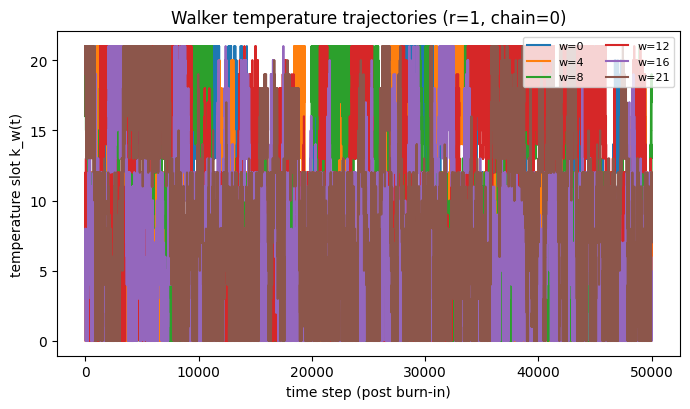

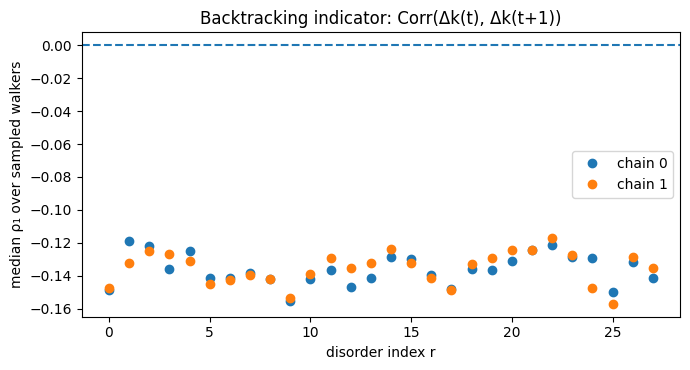

In [11]:
out=pt_diagnostics_report(
    I_ts_stack1,
    betas1,
    acc_stack1)